# Fine-tuning CamemBERT

In [1]:
#Import des bibliothèques

In [2]:
!pip install -q transformers datasets

In [3]:
!pip install accelerate

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

In [5]:
from datasets import DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
import torch

from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler 
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

from transformers import CamembertForSequenceClassification

# Définir le device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [8]:
nltk.download('stopwords')
# Télécharger le package punkt
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/asma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/asma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import shutil
import zipfile

In [10]:
# Option pour afficher toutes les lignes d'un dataframe
#pd.set_option('display.max_rows', None)

In [11]:
data = pd.read_csv('discussions-annotations-public-.csv', delimiter=',')

In [12]:
data.head()

id                    id dgf  \
0  7963                       NaN   
1  7964                       NaN   
2    20  601ba51cb94ff759925437d6   
3    11  601c336736c1b45b238d2598   
4    35  601971b73363cef6fbdb08b3   

                                             subject  \
0                                                NaN   
1                                                NaN   
2  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
3            Lieux de vaccination contre la Covid-19   
4                  Vaccination et dépistage COVID-19   

                                               title  \
0                                                NaN   
1                                                NaN   
2              Mise à jour fichiers simulateurs 2021   
3            Coordonnées des centres de vaccinations   
4  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   

                                            messages  \
0                                                NaN   
1                                                NaN   
2  Bonjour, suite à la mise à jour de mon simulat...   
3  Bonjour, j'ai contacté le centre de vaccinatio...   
4  Annonce faite dans les médias qui veulent souv...   

                         Annotation   categorie           created  \
0                               NaN         NaN               NaN   
1                               NaN         NaN               NaN   
2          Incohérence des données   Fiabilité   2021-02-04 08:41   
3  Questions ou remarques d'usagers       Autre  2021-02-04 18:48   
4           Commentaire sans valeur       Autre  2021-02-02 16:37   

   message auto Plusieurs sujets  
0           NaN              NaN  
1           NaN              NaN  
2           NaN              NaN  
3           NaN              NaN  
4           NaN              NaN

In [13]:
df = data.drop(["id", "message auto", "Plusieurs sujets"], axis=1)

In [14]:
df.head()

id dgf  \
0                       NaN   
1                       NaN   
2  601ba51cb94ff759925437d6   
3  601c336736c1b45b238d2598   
4  601971b73363cef6fbdb08b3   

                                             subject  \
0                                                NaN   
1                                                NaN   
2  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
3            Lieux de vaccination contre la Covid-19   
4                  Vaccination et dépistage COVID-19   

                                               title  \
0                                                NaN   
1                                                NaN   
2              Mise à jour fichiers simulateurs 2021   
3            Coordonnées des centres de vaccinations   
4  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   

                                            messages  \
0                                                NaN   
1                                                NaN   
2  Bonjour, suite à la mise à jour de mon simulat...   
3  Bonjour, j'ai contacté le centre de vaccinatio...   
4  Annonce faite dans les médias qui veulent souv...   

                         Annotation   categorie           created  
0                               NaN         NaN               NaN  
1                               NaN         NaN               NaN  
2          Incohérence des données   Fiabilité   2021-02-04 08:41  
3  Questions ou remarques d'usagers       Autre  2021-02-04 18:48  
4           Commentaire sans valeur       Autre  2021-02-02 16:37

In [15]:
df.shape

(7961, 7)

In [16]:
# Suppression des NaNs ('messages', 'Annotation', 'categorie')

In [17]:
print("Nombre de valeurs manquantes dans df['messages'] :", df.messages.isna().sum())
print("Nombre de valeurs manquantes dans df['Annotation'] :", df['Annotation'].isna().sum())
print("Nombre de valeurs manquantes dans df['categorie'] :", df['categorie'].isna().sum())

Nombre de valeurs manquantes dans df['messages'] : 2
Nombre de valeurs manquantes dans df['Annotation'] : 11
Nombre de valeurs manquantes dans df['categorie'] : 11


In [18]:
total_nan_rows = sum(df['messages'].isna() | df['Annotation'].isna() | df['categorie'].isna())
print("Nombre total de lignes avec des NaNs dans les trois colonnes :", total_nan_rows)

Nombre total de lignes avec des NaNs dans les trois colonnes : 11


In [19]:
# Suppression des lignes où les colonnes contiennent des NaNs
df.dropna(subset=["messages", "Annotation", "categorie"], inplace=True)

# Réinitialisation de l'index
df = df.reset_index(drop=True)

In [20]:
# Vérification de la suppression des NaNs
print("Nombre de valeurs manquantes dans df['messages'] :", df.messages.isna().sum())
print("Nombre de valeurs manquantes dans df['Annotation'] :", df['Annotation'].isna().sum())
print("Nombre de valeurs manquantes dans df['categorie'] :", df['categorie'].isna().sum())

Nombre de valeurs manquantes dans df['messages'] : 0
Nombre de valeurs manquantes dans df['Annotation'] : 0
Nombre de valeurs manquantes dans df['categorie'] : 0


In [21]:
df.shape

(7950, 7)

In [22]:
df.head()

id dgf  \
0  601ba51cb94ff759925437d6   
1  601c336736c1b45b238d2598   
2  601971b73363cef6fbdb08b3   
3  601cf95e3f8affb8232057a8   
4  601a99d34d7375a1d7b5f753   

                                             subject  \
0  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
1            Lieux de vaccination contre la Covid-19   
2                  Vaccination et dépistage COVID-19   
3  Base Sirene des entreprises et de leurs établi...   
4  Hydrométrie - situation hydrologique en Bretag...   

                                               title  \
0              Mise à jour fichiers simulateurs 2021   
1            Coordonnées des centres de vaccinations   
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   
3                                 Manque d'effectifs   
4                           Temporalité des données    

                                            messages  \
0  Bonjour, suite à la mise à jour de mon simulat...   
1  Bonjour, j'ai contacté le centre de vaccinatio...   
2  Annonce faite dans les médias qui veulent souv...   
3  Bonjour,\nje constate une disparition d'un gra...   
4  Nous souhaiterions utilisé ces données. nous r...   

                         Annotation       categorie           created  
0          Incohérence des données       Fiabilité   2021-02-04 08:41  
1  Questions ou remarques d'usagers           Autre  2021-02-04 18:48  
2           Commentaire sans valeur           Autre  2021-02-02 16:37  
3          Incohérence des données       Fiabilité   2021-02-05 08:53  
4            Erreur d'actualisation  Actualisation   2021-02-03 13:40

In [23]:
df.columns

Index(['id dgf', 'subject', 'title', 'messages', 'Annotation', 'categorie',
       'created'],
      dtype='object')

In [24]:
df.describe()

id dgf  \
count                       7950   
unique                      7950   
top     601ba51cb94ff759925437d6   
freq                           1   

                                                  subject  \
count                                                7946   
unique                                               2631   
top     Base Sirene des entreprises et de leurs établi...   
freq                                                  327   

                                                    title messages  \
count                                                7950     7950   
unique                                               6544     7663   
top     Suggestion d'un nouveau mot-clé pour améliorer...  DELETED   
freq                                                  130       62   

                              Annotation       categorie           created  
count                               7950            7950              7947  
unique                                28               8              7722  
top     Questions ou remarques d'usagers  Accessibilité   2019-03-27 15:28  
freq                                1419            2579                55

In [25]:
# Ajout d'une colonne qui concatène la colonne 'messages' et la colonne 'title'
df['combined_text'] = df['title'] + ' ' + df['messages']

In [26]:
df.head()

id dgf  \
0  601ba51cb94ff759925437d6   
1  601c336736c1b45b238d2598   
2  601971b73363cef6fbdb08b3   
3  601cf95e3f8affb8232057a8   
4  601a99d34d7375a1d7b5f753   

                                             subject  \
0  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
1            Lieux de vaccination contre la Covid-19   
2                  Vaccination et dépistage COVID-19   
3  Base Sirene des entreprises et de leurs établi...   
4  Hydrométrie - situation hydrologique en Bretag...   

                                               title  \
0              Mise à jour fichiers simulateurs 2021   
1            Coordonnées des centres de vaccinations   
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   
3                                 Manque d'effectifs   
4                           Temporalité des données    

                                            messages  \
0  Bonjour, suite à la mise à jour de mon simulat...   
1  Bonjour, j'ai contacté le centre de vaccinatio...   
2  Annonce faite dans les médias qui veulent souv...   
3  Bonjour,\nje constate une disparition d'un gra...   
4  Nous souhaiterions utilisé ces données. nous r...   

                         Annotation       categorie           created  \
0          Incohérence des données       Fiabilité   2021-02-04 08:41   
1  Questions ou remarques d'usagers           Autre  2021-02-04 18:48   
2           Commentaire sans valeur           Autre  2021-02-02 16:37   
3          Incohérence des données       Fiabilité   2021-02-05 08:53   
4            Erreur d'actualisation  Actualisation   2021-02-03 13:40   

                                       combined_text  
0  Mise à jour fichiers simulateurs 2021 Bonjour,...  
1  Coordonnées des centres de vaccinations Bonjou...  
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...  
3  Manque d'effectifs Bonjour,\nje constate une d...  
4  Temporalité des données  Nous souhaiterions ut...

# Les catégories

In [27]:
df['categorie'].value_counts()

Accessibilité                     2579
Autre                             2211
Actualisation                     1213
Fiabilité                          897
Exploitabilité                     577
Compréhension                      471
Autre, Actualisation                 1
Accessibilité , Accessibilité        1
Name: categorie, dtype: int64

In [28]:
# On enlève les espaces en trop des noms de catégories
def preprocess_categories(text):
    # Supprimer les espaces en trop
    text_nspaces = re.sub(r'\s+', '', text)
    return text_nspaces

In [29]:
# Appliquer la fonction de prétraitement sur la colonne
df['categorie'] = df['categorie'].apply(preprocess_categories)

In [30]:
df['categorie'].value_counts()

Accessibilité                  2579
Autre                          2211
Actualisation                  1213
Fiabilité                       897
Exploitabilité                  577
Compréhension                   471
Autre,Actualisation               1
Accessibilité,Accessibilité       1
Name: categorie, dtype: int64

In [31]:
df['categorie'].unique()

array(['Fiabilité', 'Autre', 'Actualisation', 'Accessibilité',
       'Compréhension', 'Exploitabilité', 'Autre,Actualisation',
       'Accessibilité,Accessibilité'], dtype=object)

In [32]:
df['categorie'].nunique()

8

In [33]:
# On retire les catégories d'annotations multiples
mask = df['categorie'].isin(["Autre,Actualisation", "Accessibilité,Accessibilité"])
#df[mask].index
df = df.drop(df[mask].index)

# Réinitialiser l'index
df = df.reset_index(drop=True)

In [34]:
df['categorie'].value_counts()

Accessibilité     2579
Autre             2211
Actualisation     1213
Fiabilité          897
Exploitabilité     577
Compréhension      471
Name: categorie, dtype: int64

In [35]:
df['categorie'].nunique()

6

In [36]:
df.shape

(7948, 8)

In [37]:
df.head()

id dgf  \
0  601ba51cb94ff759925437d6   
1  601c336736c1b45b238d2598   
2  601971b73363cef6fbdb08b3   
3  601cf95e3f8affb8232057a8   
4  601a99d34d7375a1d7b5f753   

                                             subject  \
0  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
1            Lieux de vaccination contre la Covid-19   
2                  Vaccination et dépistage COVID-19   
3  Base Sirene des entreprises et de leurs établi...   
4  Hydrométrie - situation hydrologique en Bretag...   

                                               title  \
0              Mise à jour fichiers simulateurs 2021   
1            Coordonnées des centres de vaccinations   
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   
3                                 Manque d'effectifs   
4                           Temporalité des données    

                                            messages  \
0  Bonjour, suite à la mise à jour de mon simulat...   
1  Bonjour, j'ai contacté le centre de vaccinatio...   
2  Annonce faite dans les médias qui veulent souv...   
3  Bonjour,\nje constate une disparition d'un gra...   
4  Nous souhaiterions utilisé ces données. nous r...   

                         Annotation      categorie           created  \
0          Incohérence des données       Fiabilité  2021-02-04 08:41   
1  Questions ou remarques d'usagers          Autre  2021-02-04 18:48   
2           Commentaire sans valeur          Autre  2021-02-02 16:37   
3          Incohérence des données       Fiabilité  2021-02-05 08:53   
4            Erreur d'actualisation  Actualisation  2021-02-03 13:40   

                                       combined_text  
0  Mise à jour fichiers simulateurs 2021 Bonjour,...  
1  Coordonnées des centres de vaccinations Bonjou...  
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...  
3  Manque d'effectifs Bonjour,\nje constate une d...  
4  Temporalité des données  Nous souhaiterions ut...

In [38]:
# Création des tables de correspondances id2label et label2id pour numériser nos catégories

In [39]:
# Définir les labels
#labels = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6']
labels = df['categorie'].unique().tolist()
print(labels)

['Fiabilité', 'Autre', 'Actualisation', 'Accessibilité', 'Compréhension', 'Exploitabilité']


In [40]:
# Créer des dictionnaires pour convertir les identifiants de label et les labels
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [41]:
print(id2label)

{0: 'Fiabilité', 1: 'Autre', 2: 'Actualisation', 3: 'Accessibilité', 4: 'Compréhension', 5: 'Exploitabilité'}


In [42]:
print(label2id)

{'Fiabilité': 0, 'Autre': 1, 'Actualisation': 2, 'Accessibilité': 3, 'Compréhension': 4, 'Exploitabilité': 5}


In [43]:
# Division du jeu de données (Train/Validation/Test set)

In [44]:
# Diviser le jeu de données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['categorie'])

# Diviser l'ensemble d'entraînement en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['categorie'])

# Créer des Datasets pour les ensembles train, validation et test
train_dataset = Dataset.from_pandas(train_df[['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie']])
val_dataset = Dataset.from_pandas(val_df[['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie']])
test_dataset = Dataset.from_pandas(test_df[['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie']])

# Créer un DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie', '__index_level_0__'],
        num_rows: 5086
    })
    validation: Dataset({
        features: ['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie', '__index_level_0__'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['id dgf', 'subject', 'title', 'messages', 'combined_text', 'Annotation', 'categorie', '__index_level_0__'],
        num_rows: 1590
    })
})


In [45]:
# Affichage des différents datasets après division

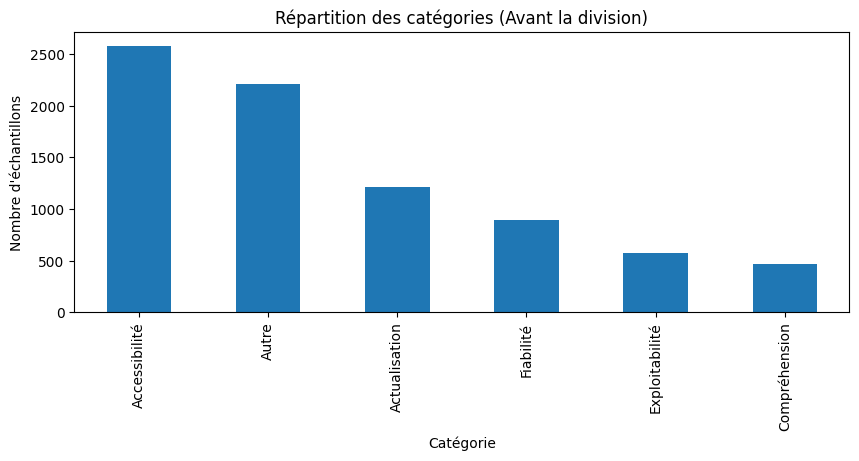

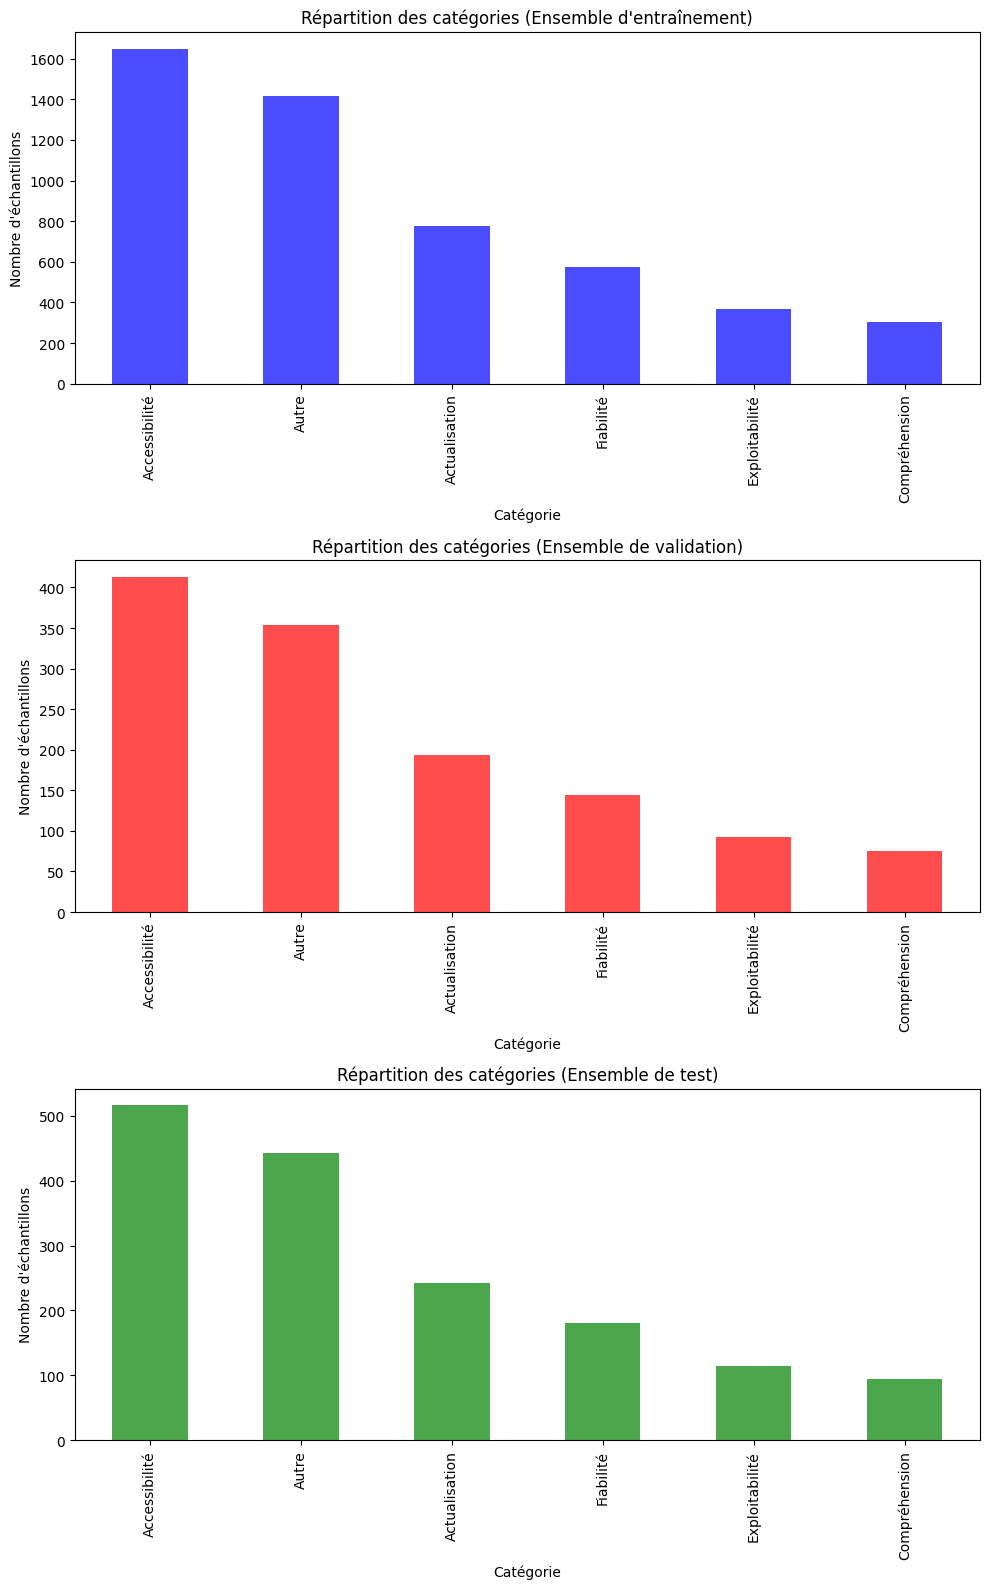

Train : 
 Accessibilité     1650
Autre             1415
Actualisation      776
Fiabilité          573
Exploitabilité     370
Compréhension      302
Name: categorie, dtype: int64


Validation : 
 Accessibilité     413
Autre             354
Actualisation     194
Fiabilité         144
Exploitabilité     92
Compréhension      75
Name: categorie, dtype: int64


Test : 
 Accessibilité     516
Autre             442
Actualisation     243
Fiabilité         180
Exploitabilité    115
Compréhension      94
Name: categorie, dtype: int64


In [46]:
# Avant la division
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Répartition des catégories (Avant la division)")
df['categorie'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'échantillons")

# Après la division
train_counts = train_df['categorie'].value_counts()
val_counts = val_df['categorie'].value_counts()
test_counts = test_df['categorie'].value_counts()

# Répartition des catégories dans train_df
plt.figure(figsize=(10, 16))
plt.subplot(3, 1, 1)
plt.title("Répartition des catégories (Ensemble d'entraînement)")
train_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'échantillons")

# Répartition des catégories dans val_df
plt.subplot(3, 1, 2)
plt.title("Répartition des catégories (Ensemble de validation)")
val_counts.plot(kind='bar', color='red', alpha=0.7)
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'échantillons")

# Répartition des catégories dans test_df
plt.subplot(3, 1, 3)
plt.title("Répartition des catégories (Ensemble de test)")
test_counts.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'échantillons")

plt.tight_layout()
plt.show()

print('Train : \n', train_counts)
print('\n')
print('Validation : \n', val_counts)
print('\n')
print('Test : \n', test_counts)

In [47]:
# On vérifie le premier exemple de l'ensemble de train

In [48]:
example = dataset['train'][0]
example

{'id dgf': '56981b6288ee3813e8b7e1f8',
 'subject': 'Gares ferroviaires de tous types,exploitées ou non',
 'title': 'Certificat expiré',
 'messages': "Le certificat associé à static.data.gouv.fr est périmé. Message du navigateur quand on essaie de télécharger la ressource : Le certificat a expiré le mercredi 16 décembre 2015 07:41. De plus, si on essaie de passer en http simple, on est redirigé sur https. Du coup, cette source n'est plus accessible, tout comme de nombreuses autres.",
 'combined_text': "Certificat expiré Le certificat associé à static.data.gouv.fr est périmé. Message du navigateur quand on essaie de télécharger la ressource : Le certificat a expiré le mercredi 16 décembre 2015 07:41. De plus, si on essaie de passer en http simple, on est redirigé sur https. Du coup, cette source n'est plus accessible, tout comme de nombreuses autres.",
 'Annotation': 'Lien mort',
 'categorie': 'Accessibilité',
 '__index_level_0__': 2973}

# Preprocessing des données

In [49]:
# Prétraitement et tokenisation à l'aide du tokenizer

In [50]:
# Créer un tokenizer
tokenizer = AutoTokenizer.from_pretrained("camembert-base", do_lower_case=True)

# Créer le modèle CamemBERT
model = AutoModel.from_pretrained("camembert-base")

# Fonction de prétraitement pour encoder les exemples et ajouter les labels
def preprocess_data(examples):
    # Nettoyage du texte
    combined_text = examples["combined_text"]

    # Convertir chaque texte en minuscules
    combined_text = [text.lower() for text in combined_text]

    # Supprimer les chiffres
    combined_text = [re.sub(r'\d+', '', text) for text in combined_text]

    # Supprimer les adresses mail
    combined_text = [re.sub(r'\S+@\S+', '', text) for text in combined_text]

    # Supprimer les caractères de ponctuation sauf les apostrophes et les accents
    combined_text = [re.sub(r"[^\w\s'-.]", '', text) for text in combined_text]

    # Supprimer certains mots vides
    words_to_remove = ['bonjour', 'bonsoir', 'bonne journée', 'cordialement', 'merci', 'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'aout', 'septembre', 'octobre', 'novembre', 'décembre']
    combined_text = [[word for word in text.split() if word not in words_to_remove] for text in combined_text]
    combined_text = [' '.join(text) for text in combined_text]

    # Supprimer les espaces en trop et les sauts de lignes
    combined_text = [re.sub(r'\s+', ' ', text) for text in combined_text]
    combined_text = [text.strip() for text in combined_text]

    # Ajouter les labels numérisés
    #label_ids = [label2id[label] for label in examples["categorie"]]

    return combined_text

# Fonction pour l'encodage des textes et l'ajout des labels et des embeddings
def tokenization(examples):
    # Appeler la fonction preprocess_data pour obtenir les textes prétraités
    combined_text = preprocess_data(examples)

    # Récupérer les labels directement depuis les exemples
    labels = examples["categorie"]

    # Convertir les labels en identifiants numériques à l'aide de label2id
    label_ids = [label2id[label] for label in labels]

    # Encoder les textes avec le tokenizer
    encoding = tokenizer(combined_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    #encoding = tokenizer(combined_text, padding="max_length", truncation=True, max_length=2, return_tensors="pt")

    # Obtenir les embeddings des tokens
    with torch.no_grad():
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        embeddings = outputs.last_hidden_state

    # Ajouter les labels et les embeddings à l'encodage des exemples
    encoding["labels"] = label_ids
    encoding["embeddings"] = embeddings
    
    return encoding

# Appliquer la fonction tokenization pour obtenir l'encodage des exemples
encoded_dataset = dataset.map(tokenization, batched=True, remove_columns=dataset['train'].column_names)

print(encoded_dataset)

Map:   0%|          | 0/5086 [00:00<?, ? examples/s]

Map:   0%|          | 0/1272 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 5086
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 1590
    })
})


In [51]:
"""# Créer un tokenizer
tokenizer = AutoTokenizer.from_pretrained("camembert-base", do_lower_case=True)

# Créer le modèle CamemBERT
model = AutoModel.from_pretrained("camembert-base")

# Fonction de prétraitement pour encoder les exemples et ajouter les labels
def preprocess_data(examples):
    # Nettoyage du texte
    combined_text = examples["combined_text"]

    # Convertir chaque texte en minuscules
    combined_text = [text.lower() for text in combined_text]

    # Supprimer les chiffres
    combined_text = [re.sub(r'\d+', '', text) for text in combined_text]

    # Supprimer les adresses mail
    combined_text = [re.sub(r'\S+@\S+', '', text) for text in combined_text]

    # Supprimer les caractères de ponctuation sauf les apostrophes et les accents
    combined_text = [re.sub(r"[^\w\s'-.]", '', text) for text in combined_text]

    # Supprimer certains mots vides
    words_to_remove = ['bonjour', 'bonsoir', 'bonne journée', 'cordialement', 'merci', 'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'aout', 'septembre', 'octobre', 'novembre', 'décembre']
    combined_text = [[word for word in text.split() if word not in words_to_remove] for text in combined_text]
    combined_text = [' '.join(text) for text in combined_text]

    # Supprimer les espaces en trop et les sauts de lignes
    combined_text = [re.sub(r'\s+', ' ', text) for text in combined_text]
    combined_text = [text.strip() for text in combined_text]

    # Ajouter les labels numérisés
    label_ids = [label2id[label] for label in examples["categorie"]]

    return {"combined_text": combined_text, "labels": label_ids}

# Fonction pour l'encodage des textes et l'ajout des labels et des embeddings
def tokenization(examples):
    # Appeler la fonction preprocess_data pour obtenir les textes prétraités
    preprocessed_data = preprocess_data(examples)
    combined_text = preprocessed_data["combined_text"]

    # Encoder les textes avec le tokenizer
    encoding = tokenizer(combined_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    #encoding = tokenizer(combined_text, padding="max_length", truncation=True, max_length=2, return_tensors="pt")

    # Obtenir les embeddings des tokens
    with torch.no_grad():
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        embeddings = outputs.last_hidden_state

    # Ajouter les labels et les embeddings à l'encodage des exemples
    encoding["labels"] = preprocessed_data["labels"]
    encoding["embeddings"] = embeddings

    return encoding

# Appliquer la fonction tokenization pour obtenir l'encodage des exemples
encoded_dataset = dataset.map(tokenization, batched=True, remove_columns=dataset['train'].column_names)

print(encoded_dataset)
"""

'# Créer un tokenizer\ntokenizer = AutoTokenizer.from_pretrained("camembert-base", do_lower_case=True)\n\n# Créer le modèle CamemBERT\nmodel = AutoModel.from_pretrained("camembert-base")\n\n# Fonction de prétraitement pour encoder les exemples et ajouter les labels\ndef preprocess_data(examples):\n    # Nettoyage du texte\n    combined_text = examples["combined_text"]\n\n    # Convertir chaque texte en minuscules\n    combined_text = [text.lower() for text in combined_text]\n\n    # Supprimer les chiffres\n    combined_text = [re.sub(r\'\\d+\', \'\', text) for text in combined_text]\n\n    # Supprimer les adresses mail\n    combined_text = [re.sub(r\'\\S+@\\S+\', \'\', text) for text in combined_text]\n\n    # Supprimer les caractères de ponctuation sauf les apostrophes et les accents\n    combined_text = [re.sub(r"[^\\w\\s\'-.]", \'\', text) for text in combined_text]\n\n    # Supprimer certains mots vides\n    words_to_remove = [\'bonjour\', \'bonsoir\', \'bonne journée\', \'cordiale

In [52]:
train_dataset = encoded_dataset['train']
for i in range(3):
    example = train_dataset[i]
    print(f"Exemple {i+1}:")
    for column in example.keys():
        print(f"{column}: {example[column]}")
    print()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Exemple 3:
input_ids: [5, 777, 4305, 8, 513, 5061, 7, 50, 20642, 1207, 28, 777, 38, 9, 9895, 526, 936, 8, 117, 19, 4305, 8, 513, 21, 27965, 491, 15, 17, 11, 4515, 945, 9, 404, 264, 26, 662, 5131, 17284, 895, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels: 3
embeddings: [[0.03169205039739609, 0.13399243354797363, 0.05465039238333702, 0.0008524000295437872, -0.03629275038

In [53]:
# Affichage du résultat du preprocessing sur un exemple

example = encoded_dataset['train'][0]
print(example)
print('\n')
print(example.keys())
#print('\n')
#print(example.values())

{'input_ids': [5, 6282, 1017, 6277, 141, 16, 6282, 4003, 15, 11556, 2906, 9, 12818, 9, 18690, 9, 427, 30, 6606, 2037, 9, 1144, 25, 5068, 206, 91, 8585, 8, 2647, 13, 7101, 16, 6282, 33, 1017, 6277, 141, 16, 1600, 21, 9, 8, 40, 7, 86, 91, 8585, 8, 444, 22, 1221, 445, 7, 91, 30, 30503, 32, 3047, 9, 25, 392, 7, 78, 1099, 49, 11, 41, 40, 2754, 7, 66, 79, 8, 720, 214, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 3, 'embeddings': [[-0.05475762113928795, 0.05290324240922928,

In [54]:
# Décodage de l'exemple pour 'dénumériser' l'exemple

tokenizer.decode(example['input_ids'])

"<s> certificat expiré le certificat associé à static.data.gouv.fr est périmé. message du navigateur quand on essaie de télécharger la ressource le certificat a expiré le mercredi. de plus, si on essaie de passer en http simple, on est redirigé sur https. du coup, cette source n'est plus accessible, tout comme de nombreuses autres.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [55]:
# Affichage du label de l'exemple ci-dessus après l'étape de preprocessing

In [56]:
label = example['labels']
print(label)
print(id2label[label])

3
Accessibilité


# Définition du modèle CamemBERT

In [57]:
"""# Calculez les poids de classe
#batch_size=16
class_labels = train_df['categorie'].unique().tolist()
class_counts = train_df['categorie'].value_counts()
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_df['categorie'].map(label2id).values]


# Afficher les poids attribués à chaque classe
print("Poids assignés à chaque classe :")
for label_id, weight in enumerate(sample_weights.tolist()):
    label_name = id2label[label_id]
    print(f"{label_name}: {weight}")
    print('\n')

# Créez un WeightedRandomSampler pour l'ensemble d'entraînement
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Créez un DataLoader avec le WeightedRandomSampler
train_loader = DataLoader(encoded_dataset['train'], batch_size=batch_size, sampler=sampler)
"""

'# Calculez les poids de classe\n#batch_size=16\nclass_labels = train_df[\'categorie\'].unique().tolist()\nclass_counts = train_df[\'categorie\'].value_counts()\nclass_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)\nsample_weights = class_weights[train_df[\'categorie\'].map(label2id).values]\n\n\n# Afficher les poids attribués à chaque classe\nprint("Poids assignés à chaque classe :")\nfor label_id, weight in enumerate(sample_weights.tolist()):\n    label_name = id2label[label_id]\n    print(f"{label_name}: {weight}")\n    print(\'\n\')\n\n# Créez un WeightedRandomSampler pour l\'ensemble d\'entraînement\nsampler = WeightedRandomSampler(sample_weights, len(sample_weights))\n\n# Créez un DataLoader avec le WeightedRandomSampler\ntrain_loader = DataLoader(encoded_dataset[\'train\'], batch_size=batch_size, sampler=sampler)\n'

In [58]:
# Définir la taille du lot et la métrique d'évaluation
#batch_size = 8
batch_size = 16
#batch_size = 32
#batch_size = len(encoded_dataset['train'])
#metric_name = "f1"
metric_name = "accuracy"

# Définir les arguments pour l'entraînement
args = TrainingArguments(
    "bert-finetuned-my-data",
    #f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    #learning_rate=2e-6,
    #learning_rate=1e-5,
    #learning_rate=2e-5,
    learning_rate=3e-5,
    #learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [59]:
from transformers import AdamW, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained("camembert-base",
                                                           problem_type="single_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

# Variables globales pour stocker y_true et y_pred
y_true_global = None
y_pred_global = None

#Définition de la fonction compute_metrics
def compute_metrics(eval_pred):
    global y_true_global, y_pred_global

    predictions, y_true = eval_pred
    y_pred = predictions.argmax(axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Assigner les valeurs à y_true_global et y_pred_global
    y_true_global = y_true.tolist()
    y_pred_global = y_pred.tolist()

    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

    return metrics


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
# Création de l'optimiseur AdamW avec le taux d'apprentissage spécifié
optimizer = AdamW(model.parameters(), lr=args.learning_rate)

# Création d'une instance de la classe Trainer en spécifiant l'optimiseur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    #train_dataset=train_loader.dataset,
    eval_dataset=encoded_dataset["validation"],
    optimizers=(optimizer, None),  # spécifier l'optimiseur pour l'entraînement
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Lancement de l'entraînement du modele
trainer.train()


/home/asma/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1590, training_loss=0.7260929323592276, metrics={'train_runtime': 5182.2295, 'train_samples_per_second': 4.907, 'train_steps_per_second': 0.307, 'total_flos': 1672788609469440.0, 'train_loss': 0.7260929323592276, 'epoch': 5.0})

In [61]:
# Evaluation
# Évaluer le modèle sur l'ensemble de test
eval_results = trainer.evaluate(encoded_dataset['test'])
print(eval_results)

{'eval_loss': 0.9926791787147522, 'eval_accuracy': 0.7182389937106918, 'eval_f1': 0.7154476658487445, 'eval_precision': 0.7168117201187565, 'eval_recall': 0.7182389937106918, 'eval_runtime': 87.9158, 'eval_samples_per_second': 18.085, 'eval_steps_per_second': 1.137, 'epoch': 5.0}


In [62]:
# Afficher les valeurs de y_true_global et y_pred_global
print("y_true_global:", y_true_global)
print("y_pred_global:", y_pred_global)

y_true_global: [3, 1, 3, 4, 2, 1, 0, 2, 0, 4, 1, 3, 3, 4, 3, 1, 3, 5, 3, 1, 1, 4, 3, 3, 1, 0, 2, 5, 2, 2, 3, 4, 3, 3, 3, 1, 3, 2, 3, 3, 2, 3, 1, 2, 0, 3, 2, 1, 3, 4, 0, 1, 0, 3, 2, 1, 0, 2, 5, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 5, 1, 1, 2, 2, 3, 1, 2, 3, 5, 3, 3, 2, 0, 1, 3, 3, 4, 4, 0, 0, 1, 1, 1, 1, 3, 3, 3, 0, 4, 2, 1, 3, 1, 1, 5, 3, 3, 0, 3, 1, 1, 2, 4, 3, 2, 0, 3, 1, 1, 3, 4, 3, 3, 1, 3, 1, 2, 1, 2, 4, 2, 1, 4, 1, 0, 5, 1, 3, 5, 1, 0, 4, 3, 1, 2, 3, 0, 3, 5, 0, 2, 1, 3, 2, 1, 1, 1, 3, 0, 1, 4, 1, 0, 3, 0, 1, 2, 1, 5, 3, 3, 1, 2, 3, 2, 3, 2, 3, 1, 0, 3, 5, 3, 3, 2, 3, 2, 2, 0, 3, 5, 5, 0, 1, 3, 1, 3, 3, 3, 4, 1, 5, 3, 4, 5, 3, 0, 1, 3, 2, 3, 3, 2, 2, 0, 3, 2, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 2, 3, 2, 5, 3, 2, 2, 1, 0, 3, 3, 2, 0, 3, 1, 0, 2, 0, 0, 0, 1, 5, 1, 3, 5, 3, 2, 3, 2, 4, 1, 2, 1, 5, 0, 3, 3, 0, 1, 3, 1, 1, 2, 3, 1, 1, 1, 3, 2, 3, 3, 2, 3, 5, 2, 3, 1, 5, 3, 1, 1, 1, 1, 4, 3, 3, 1, 2, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 1, 1, 2, 3, 3, 2, 1, 2, 1, 1, 0, 1, 

In [63]:
y_true = y_true_global
y_pred = y_pred_global

# Evaluation du modèle : Rapport de classification

In [64]:
target_names = [label for _, label in sorted(id2label.items())]
target_names

['Fiabilité',
 'Autre',
 'Actualisation',
 'Accessibilité',
 'Compréhension',
 'Exploitabilité']

In [65]:
labels

['Fiabilité',
 'Autre',
 'Actualisation',
 'Accessibilité',
 'Compréhension',
 'Exploitabilité']

In [66]:
id2label

{0: 'Fiabilité',
 1: 'Autre',
 2: 'Actualisation',
 3: 'Accessibilité',
 4: 'Compréhension',
 5: 'Exploitabilité'}

In [67]:
# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=labels)
#report = classification_report(y_true, y_pred)

# Afficher le rapport de classification
print(report)

                precision    recall  f1-score   support

     Fiabilité       0.59      0.66      0.62       180
         Autre       0.76      0.73      0.75       442
 Actualisation       0.76      0.77      0.76       243
 Accessibilité       0.74      0.80      0.77       516
 Compréhension       0.69      0.52      0.59        94
Exploitabilité       0.58      0.44      0.50       115

      accuracy                           0.72      1590
     macro avg       0.69      0.65      0.67      1590
  weighted avg       0.72      0.72      0.72      1590



In [68]:
df['categorie'].value_counts()

Accessibilité     2579
Autre             2211
Actualisation     1213
Fiabilité          897
Exploitabilité     577
Compréhension      471
Name: categorie, dtype: int64

# Evaluation du modèle : Matrice de confusion

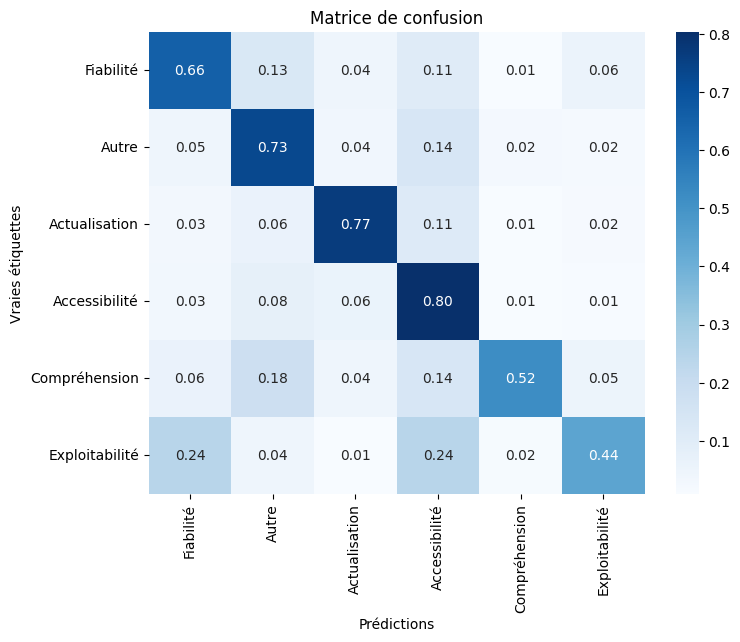

In [69]:
# Calculer la matrice de confusion
confusion_mat = confusion_matrix(y_true, y_pred)

# Obtenir les noms des classes à partir des identifiants de label
class_names = [id2label[i] for i in range(len(labels))]

# Normaliser la matrice de confusion pour afficher les pourcentages
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Créer une figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de confusion
sns.heatmap(confusion_mat_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Ajouter des étiquettes aux axes
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")

# Ajouter un titre
plt.title("Matrice de confusion")

# Afficher la figure
plt.show()

# Recharger le modèle pré-entrainé (non zippé)

In [70]:
"""# Sauvegarde du modèle pré-entraîné

# Chemin de destination pour enregistrer le modèle et le tokenizer
output_dir = "modeleBertSaved"

# Enregistrer le modèle
model.save_pretrained(output_dir)

# Enregistrer le tokenizer
tokenizer.save_pretrained(output_dir)
"""

'# Sauvegarde du modèle pré-entraîné\n\n# Chemin de destination pour enregistrer le modèle et le tokenizer\noutput_dir = "modeleBertSaved"\n\n# Enregistrer le modèle\nmodel.save_pretrained(output_dir)\n\n# Enregistrer le tokenizer\ntokenizer.save_pretrained(output_dir)\n'

In [71]:
"""# Rechargement du modèle pré-entraîné

# Charger le modèle à partir du dossier sauvegardé
model_saved = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Charger le tokenizer à partir du dossier sauvegardé
tokenizer_saved = AutoTokenizer.from_pretrained(output_dir)
"""

'# Rechargement du modèle pré-entraîné\n\n# Charger le modèle à partir du dossier sauvegardé\nmodel_saved = AutoModelForSequenceClassification.from_pretrained(output_dir)\n\n# Charger le tokenizer à partir du dossier sauvegardé\ntokenizer_saved = AutoTokenizer.from_pretrained(output_dir)\n'

# Recharger le modèle pré-entrainé (zippé)

In [72]:
# Enregistrement les fichiers de poids et d'entrainement du modele

#import shutil
#import zipfile

# Chemin de destination pour enregistrer le modèle
model_directory = "bert-finetuned-my-data-final"

# Sauvegarder le modèle avec les fichiers de poids
trainer.save_model(model_directory)
# Sauvegarder le tokenizer
tokenizer.save_pretrained(model_directory)

# Compresser le dossier au format .zip
shutil.make_archive(model_directory + "_archive", 'zip', model_directory)

# Chemin de destination pour le fichier .zip
zip_file_path = model_directory + "_archive.zip"


In [73]:
# Charger le model pré-entrainé (zippé)

# Extraire le contenu du fichier .zip dans un répertoire temporaire
zip_file_path = "bert-finetuned-my-data-final_archive.zip"
extract_dir = "extracted_model"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Charger le modèle à partir du répertoire extrait
model_saved = AutoModelForSequenceClassification.from_pretrained(extract_dir)

# Charger le tokenizer à partir du même répertoire extrait
tokenizer_saved = AutoTokenizer.from_pretrained(extract_dir)

In [74]:
# Test

# Prétraitement des nouvelles données
new_data = ["Problème avec le lien, je n'arrive pas à accéder à la page"]

encoded_inputs = tokenizer_saved(new_data, truncation=True, padding=True, return_tensors="pt")

# Passage des données dans le modèle pour l'inférence
with torch.no_grad():
    outputs = model_saved(**encoded_inputs)

# Récupération des prédictions
predictions = outputs.logits
predicted_labels = torch.argmax(predictions, dim=1)

# Affichage des résultats
for text, label in zip(new_data, predicted_labels):
    print(f"Texte : {text}")
    print(f"Label prédit : {label}")
    #print(type(label))
    label = label.item()
    #print(type(label))
    print(f"Nom du label prédit : {id2label[label]}")

Texte : Problème avec le lien, je n'arrive pas à accéder à la page
Label prédit : 3
Nom du label prédit : Accessibilité


# Inférence avec les données du MEFSIN

In [75]:
# Chargement des données du MEFSIN

df_MEFSIN = pd.read_csv("DISCUSSIONS_MEFSIN_DATAGOUV_27032023.csv")

#df_MEFSIN = pd.read_csv("Jeu_MEFSIN_Asma.csv")

In [76]:
df_MEFSIN.head()

id              user  \
0  6418839138db635b9a8ec61a  Christophe BADOL   
1  641861cca4f1971589503cb9      Estelle CrÄ   
2  6413358dcce10824f53a9bc9     Camille Bacon   
3  64088027de783a9eadb04349               JÄ   
4  640869f8abc8970cefa9c3d4        Anne Solaz   

                                             subject  \
0                          Parcellaire Express (PCI)   
1  Fichiers des locaux et des parcelles des perso...   
2                        Demandes de valeurs fonciÄ   
3   Prix des carburants en France - Flux instantanÄ   
4                                            L'impÄ   

                                               title  size  \
0  Disparition de la table arrondissement de la l...     2   
1                                       Siren cessÄ     1   
2                                  1 idloc = 1 local     1   
3            Date d'obsolescence de ce jeu de donnÄ     1   
4                             liens non focntionnels     1   

                                            messages  \
0  Bonjour,\n\nla table arrondissement a disparu ...   
1     Bonjour, Pourquoi y a-t-il des Siren dont l'Ä   
2    Bonjour,\n\nTout d'abord, merci pour ces donnÄ   
3           Bonjour, la description du jeu de donnÄ   
4                        Bonjour, Je n'arrive pas Ä   

                      created closed closed_by  MEFSIN  
0  2023-03-20T17:02:25.636000    NaN       NaN       1  
1  2023-03-20T14:38:20.353000    NaN       NaN       1  
2  2023-03-16T16:28:13.300000    NaN       NaN       1  
3  2023-03-08T13:31:35.125000    NaN       NaN       1  
4  2023-03-08T11:56:56.125000    NaN       NaN       1

In [77]:
"""# Remplacement des encodages incorrectes
def corriger_encodage(df, colonnes):
    for colonne in colonnes:
        df[colonne] = df[colonne].str.replace('Ã©', 'é')
        df[colonne] = df[colonne].str.replace('Ã©', 'é')
        df[colonne] = df[colonne].str.replace('à¨', 'è')
        df[colonne] = df[colonne].str.replace('Ãª', 'ê')
        df[colonne] = df[colonne].str.replace('à‰', 'É')
        df[colonne] = df[colonne].str.replace('Ã', 'à')
        df[colonne] = df[colonne].str.replace('à¢', 'â')
        df[colonne] = df[colonne].str.replace('à´', 'ô')
        df[colonne] = df[colonne].str.replace('à®', 'î')
        df[colonne] = df[colonne].str.replace('à§', 'ç')
        df[colonne] = df[colonne].str.replace('â€™', '\'')
        df[colonne] = df[colonne].str.replace('à€', 'À')
        df[colonne] = df[colonne].str.replace('Â', '')
    return df

df_MEFSIN = corriger_encodage(df_MEFSIN, ['user', 'subject', 'title', 'messages'])
"""

"# Remplacement des encodages incorrectes\ndef corriger_encodage(df, colonnes):\n    for colonne in colonnes:\n        df[colonne] = df[colonne].str.replace('Ã©', 'é')\n        df[colonne] = df[colonne].str.replace('Ã©', 'é')\n        df[colonne] = df[colonne].str.replace('à¨', 'è')\n        df[colonne] = df[colonne].str.replace('Ãª', 'ê')\n        df[colonne] = df[colonne].str.replace('à‰', 'É')\n        df[colonne] = df[colonne].str.replace('Ã', 'à')\n        df[colonne] = df[colonne].str.replace('à¢', 'â')\n        df[colonne] = df[colonne].str.replace('à´', 'ô')\n        df[colonne] = df[colonne].str.replace('à®', 'î')\n        df[colonne] = df[colonne].str.replace('à§', 'ç')\n        df[colonne] = df[colonne].str.replace('â€™', ''')\n        df[colonne] = df[colonne].str.replace('à€', 'À')\n        df[colonne] = df[colonne].str.replace('Â', '')\n    return df\n\ndf_MEFSIN = corriger_encodage(df_MEFSIN, ['user', 'subject', 'title', 'messages'])\n"

In [78]:
df_MEFSIN.head()

id              user  \
0  6418839138db635b9a8ec61a  Christophe BADOL   
1  641861cca4f1971589503cb9      Estelle CrÄ   
2  6413358dcce10824f53a9bc9     Camille Bacon   
3  64088027de783a9eadb04349               JÄ   
4  640869f8abc8970cefa9c3d4        Anne Solaz   

                                             subject  \
0                          Parcellaire Express (PCI)   
1  Fichiers des locaux et des parcelles des perso...   
2                        Demandes de valeurs fonciÄ   
3   Prix des carburants en France - Flux instantanÄ   
4                                            L'impÄ   

                                               title  size  \
0  Disparition de la table arrondissement de la l...     2   
1                                       Siren cessÄ     1   
2                                  1 idloc = 1 local     1   
3            Date d'obsolescence de ce jeu de donnÄ     1   
4                             liens non focntionnels     1   

                                            messages  \
0  Bonjour,\n\nla table arrondissement a disparu ...   
1     Bonjour, Pourquoi y a-t-il des Siren dont l'Ä   
2    Bonjour,\n\nTout d'abord, merci pour ces donnÄ   
3           Bonjour, la description du jeu de donnÄ   
4                        Bonjour, Je n'arrive pas Ä   

                      created closed closed_by  MEFSIN  
0  2023-03-20T17:02:25.636000    NaN       NaN       1  
1  2023-03-20T14:38:20.353000    NaN       NaN       1  
2  2023-03-16T16:28:13.300000    NaN       NaN       1  
3  2023-03-08T13:31:35.125000    NaN       NaN       1  
4  2023-03-08T11:56:56.125000    NaN       NaN       1

In [79]:
df_MEFSIN['combined_text'] = df_MEFSIN['title'] + ' ' + df_MEFSIN['messages']

#df_MEFSIN['combined_text'] = df_MEFSIN['title_discussion'] + ' ' + df_MEFSIN['messages_discussion']

In [80]:
df_MEFSIN.iloc[0]

id                                        6418839138db635b9a8ec61a
user                                              Christophe BADOL
subject                                  Parcellaire Express (PCI)
title            Disparition de la table arrondissement de la l...
size                                                             2
messages         Bonjour,\n\nla table arrondissement a disparu ...
created                                 2023-03-20T17:02:25.636000
closed                                                         NaN
closed_by                                                      NaN
MEFSIN                                                           1
combined_text    Disparition de la table arrondissement de la l...
Name: 0, dtype: object

In [81]:
df_MEFSIN.loc[0, "combined_text"]

'Disparition de la table arrondissement de la livraison 2023 Bonjour,\n\nla table arrondissement a disparu de la livraison au 1er janvier 2023. Sait-on pourquoi ?\nLa classe ARRONDISSEMENT nÄ\x86ÂḃÄ\x81â\x80\x9aÂỲÄ\x81â\x80\x9eÂḃest prÄ\x86'

In [82]:
#Sélection des features (X) à utiliser pour l'inférence

#features = df_MEFSIN["messages"]
###features = df_MEFSIN["combined_text"]

In [83]:
preprocessed_data = preprocess_data(df_MEFSIN)
preprocessed_data

['disparition de la table arrondissement de la livraison bonjour, la table arrondissement a disparu de la livraison au er . sait-on pourquoi la classe arrondissement näâḃäââỳäââḃest prä',
 "siren cessä bonjour, pourquoi y a-t-il des siren dont l'ä",
 "idloc local bonjour, tout d'abord, pour ces donnä",
 "date d'obsolescence de ce jeu de donnä bonjour, la description du jeu de donnä",
 "liens non focntionnels bonjour, je n'arrive pas ä",
 'plateforme non indiquä bonjour, pourriez-vous me dire si les donnä',
 'donnä ma collectivitä',
 'parcelle bt - commune de carriä bonjour, je vous contacte car je souhaiterais connaitre les ventes dans la rä',
 "lien vers le flux bonjour, j'ai quelques questions de base sur vos donnä",
 'impossible de trouver nos donnä bonjour, nos donnä',
 'vue satellite depuis quelque temps, impossible de faire des recherches sur dvf avec une vue satellite, seul lä',
 "frä bonjour, je me demandais s'il y avait une raison de faire une mise ä",
 "telechargement automat

In [84]:
#Sélection des features (X) à utiliser pour l'inférence

#features = df_MEFSIN["messages"]
#features = df_MEFSIN["combined_text"]

# Prétraitement des données d'inférence
preprocessed_data = preprocess_data(df_MEFSIN)

# Préparation des données pour l'inférence
#messages = preprocessed_data["combined_text"]

# Préparation des données pour l'inférence
messages = preprocessed_data
#messages = preprocessed_data.tolist()

# Créer une liste pour stocker les prédictions
predictions = []

# Définir la taille du batch d'inférence
batch_size = 16

# Diviser les données en lots plus petits
num_batches = len(messages) // batch_size
if len(messages) % batch_size != 0:
    num_batches += 1

# Mettre le modèle en mode évaluation
model_saved.eval()

# Parcourir les lots et effectuer l'inférence
for i in range(num_batches):
    # Sélectionner les textes du lot actuel
    batch_texts = messages[i * batch_size: (i + 1) * batch_size]

    # Appliquer le tokenizer et le modèle pour l'inférence
    with torch.no_grad():
        # Encoder les textes avec le tokenizer
        encoded_inputs = tokenizer_saved(
            batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt"
        )

        # Passage des données dans le modèle pour l'inférence
        outputs = model_saved(input_ids=encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])

    # Récupération des prédictions
    predicted_labels = torch.argmax(outputs.logits, dim=1)

    # Ajouter les prédictions à la liste des résultats
    predictions.extend(predicted_labels.tolist())

# Ajouter la liste des prédictions comme une nouvelle colonne "predictions_motifs" au DataFrame
df_MEFSIN['predictions_motifs'] = predictions
df_MEFSIN['predictions_motifs_label'] = [id2label[prediction] for prediction in predictions]


In [86]:
df_MEFSIN.head(10)

id              user  \
0  6418839138db635b9a8ec61a  Christophe BADOL   
1  641861cca4f1971589503cb9      Estelle CrÄ   
2  6413358dcce10824f53a9bc9     Camille Bacon   
3  64088027de783a9eadb04349               JÄ   
4  640869f8abc8970cefa9c3d4        Anne Solaz   
5  6408538a96433266c124be61   Pierre L'Hostis   
6  63fe2b9c047052abef06bfc1       Corinne BCD   
7  63f62c2468b60c13e99ab53c     Claude Leroux   
8  63e5e3174f42fe618e57ad7b     Iliyan Petrov   
9  63e354bd89059f1ad24d03f4               BÄ   

                                             subject  \
0                          Parcellaire Express (PCI)   
1  Fichiers des locaux et des parcelles des perso...   
2                        Demandes de valeurs fonciÄ   
3   Prix des carburants en France - Flux instantanÄ   
4                                            L'impÄ   
5                                             DonnÄ   
6                                                RÄ   
7                        Demandes de valeurs fonciÄ   
8                                                RÄ   
9                                             DonnÄ   

                                               title  size  \
0  Disparition de la table arrondissement de la l...     2   
1                                       Siren cessÄ     1   
2                                  1 idloc = 1 local     1   
3            Date d'obsolescence de ce jeu de donnÄ     1   
4                             liens non focntionnels     1   
5                            Plateforme non indiquÄ     1   
6                                             DonnÄ     1   
7                  parcelle BT2 - commune de CarriÄ     1   
8                                  Lien vers le flux     1   
9                   Impossible de trouver nos donnÄ     2   

                                            messages  \
0  Bonjour,\n\nla table arrondissement a disparu ...   
1     Bonjour, Pourquoi y a-t-il des Siren dont l'Ä   
2    Bonjour,\n\nTout d'abord, merci pour ces donnÄ   
3           Bonjour, la description du jeu de donnÄ   
4                        Bonjour, Je n'arrive pas Ä   
5    Bonjour,\n\nPourriez-vous me dire si les donnÄ   
6                          Bonjour\nMa collectivitÄ   
7  Bonjour,\nje vous contacte car je souhaiterais...   
8  Bonjour,\nJ'ai quelques questions de base sur ...   
9                               Bonjour,\nNos donnÄ   

                      created closed closed_by  MEFSIN  \
0  2023-03-20T17:02:25.636000    NaN       NaN       1   
1  2023-03-20T14:38:20.353000    NaN       NaN       1   
2  2023-03-16T16:28:13.300000    NaN       NaN       1   
3  2023-03-08T13:31:35.125000    NaN       NaN       1   
4  2023-03-08T11:56:56.125000    NaN       NaN       1   
5  2023-03-08T10:21:14.949000    NaN       NaN       1   
6  2023-02-28T17:28:12.244000    NaN       NaN       1   
7  2023-02-22T15:52:20.774000    NaN       NaN       1   
8  2023-02-10T07:24:23.623000    NaN       NaN       1   
9  2023-02-08T08:52:29.253000    NaN       NaN       1   

                                       combined_text  predictions_motifs  \
0  Disparition de la table arrondissement de la l...                   2   
1  Siren cessÄ Bonjour, Pourquoi y a-t-il des Si...                   1   
2  1 idloc = 1 local Bonjour,\n\nTout d'abord, me...                   1   
3  Date d'obsolescence de ce jeu de donnÄ Bonjou...                   2   
4  liens non focntionnels Bonjour, Je n'arrive pa...                   3   
5  Plateforme non indiquÄ Bonjour,\n\nPourriez-v...                   3   
6                   DonnÄ Bonjour\nMa collectivitÄ                   1   
7  parcelle BT2 - commune de CarriÄ Bonjour,\nje...                   1   
8  Lien vers le flux Bonjour,\nJ'ai quelques ques...                   1   
9  Impossible de trouver nos donnÄ Bonjour,\nNos...                   3   

  predictions_motifs_label  
0            Actualisation  
1                    Autre  
2    

In [87]:
# Sauvegarde des résultats d'annotations sur les grandes catégories du jeu du MEFSIN
df_MEFSIN.to_csv('Résultat_Annotations_GDMotifs.csv', index=False)

##################################################################################################################
##################################################################################################################
##################################################################################################################

# Modèle de prédictions sur les sous-motifs d'annotations (Jeu de Datactivist)

In [143]:
df['Annotation'].value_counts()

Questions ou remarques d'usagers              1419
Demande de jeu de données (set)               1067
Absence de mise à jour                         740
Lien mort                                      596
Erreur dans les données fournies               426
Absence d'information sur les mises à jour     419
Incapacité à traiter les données               384
Absence de données                             323
Absence de description des variables           270
Commentaire sans valeur                        254
Formatage non respecté                         247
Incertitude des données                        241
Format incompatible                            209
Information des réutilisateurs                 204
Descriptions imprécises                        201
Message automatique                            178
Proposition de mots-clefs                      156
Problème de granularité                        116
Incohérence des données                        107
Demande de correction          

In [144]:
#df2 = df.copy()

In [145]:
# On enlève les espaces en trop des noms de catégories
def preprocess_sscategories(df, column_name):
    # Suppression des points
    df[column_name] = df[column_name].str.replace('.', '')

    # Suppression de plus d'un espace en les remplaçant par un seul espace
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Suppression des espaces en début et fin de texte
    df[column_name] = df[column_name].str.strip()

In [146]:
# Appliquer la fonction de prétraitement sur la colonne
preprocess_sscategories(df, 'Annotation')

/tmp/ipykernel_69560/243326824.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '')


In [147]:
df['Annotation'].value_counts()

Questions ou remarques d'usagers              1419
Demande de jeu de données (set)               1067
Absence de mise à jour                         740
Lien mort                                      596
Erreur dans les données fournies               426
Absence d'information sur les mises à jour     419
Incapacité à traiter les données               384
Absence de données                             323
Absence de description des variables           270
Commentaire sans valeur                        254
Formatage non respecté                         247
Incertitude des données                        241
Format incompatible                            209
Information des réutilisateurs                 204
Descriptions imprécises                        201
Message automatique                            178
Proposition de mots-clefs                      156
Problème de granularité                        116
Incohérence des données                        107
Demande de correction          

In [150]:
df['combined_text_2'] = df['categorie'] + ' ' + df['categorie'] + ' ' + df['categorie'] + ' ' + df['title'] + ' ' + df['messages']

In [151]:
df.head()

id dgf  \
0  601ba51cb94ff759925437d6   
1  601c336736c1b45b238d2598   
2  601971b73363cef6fbdb08b3   
3  601cf95e3f8affb8232057a8   
4  601a99d34d7375a1d7b5f753   

                                             subject  \
0  Simulateur de  COUT DU CERTIFICAT D’IMMATRICUL...   
1            Lieux de vaccination contre la Covid-19   
2                  Vaccination et dépistage COVID-19   
3  Base Sirene des entreprises et de leurs établi...   
4  Hydrométrie - situation hydrologique en Bretag...   

                                               title  \
0              Mise à jour fichiers simulateurs 2021   
1            Coordonnées des centres de vaccinations   
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   
3                                 Manque d'effectifs   
4                           Temporalité des données    

                                            messages  \
0  Bonjour, suite à la mise à jour de mon simulat...   
1  Bonjour, j'ai contacté le centre de vaccinatio...   
2  Annonce faite dans les médias qui veulent souv...   
3  Bonjour,\nje constate une disparition d'un gra...   
4  Nous souhaiterions utilisé ces données. nous r...   

                         Annotation      categorie           created  \
0           Incohérence des données      Fiabilité  2021-02-04 08:41   
1  Questions ou remarques d'usagers          Autre  2021-02-04 18:48   
2           Commentaire sans valeur          Autre  2021-02-02 16:37   
3           Incohérence des données      Fiabilité  2021-02-05 08:53   
4            Erreur d'actualisation  Actualisation  2021-02-03 13:40   

                                       combined_text  \
0  Mise à jour fichiers simulateurs 2021 Bonjour,...   
1  Coordonnées des centres de vaccinations Bonjou...   
2  IL EST ANNONCE QU'IL EST POSSIBLE DE REPRENDRE...   
3  Manque d'effectifs Bonjour,\nje constate une d...   
4  Temporalité des données  Nous souhaiterions ut...   

                                     combined_text_2  
0  Fiabilité Fiabilité Fiabilité Mise à jour fich...  
1  Autre Autre Autre Coordonnées des centres de v...  
2  Autre Autre Autre IL EST ANNONCE QU'IL EST POS...  
3  Fiabilité Fiabilité Fiabilité Manque d'effecti...  
4  Actualisation Actualisation Actualisation Temp...

# Création des tables de correspondances id2sslabel et sslabel2id pour numériser nos sous-catégories

In [152]:
# Numérisation des sous-motifs d'annotations

In [153]:
df['Annotation'].nunique()

26

In [154]:
sslabels = df['Annotation'].unique().tolist()
sslabels

['Incohérence des données',
 "Questions ou remarques d'usagers",
 'Commentaire sans valeur',
 "Erreur d'actualisation",
 'Absence de mise à jour',
 'Erreur dans les données fournies',
 'Lien mort',
 'Format incompatible',
 'Information des réutilisateurs',
 'Absence de description des variables',
 'Absence de données',
 'Demande de jeu de données (set)',
 "Absence d'information sur les mises à jour",
 "Problème d'uniformité dans la saisie",
 'Incertitude des données',
 'Problème de granularité',
 'Proposition de mots-clefs',
 'Incapacité à traiter les données',
 'Formatage non respecté',
 'Source des données incorrecte ou imprécise',
 'Descriptions imprécises',
 'Données non-ouvertes',
 'Répétition des données',
 'Demande de correction',
 'Message automatique',
 'Harmonisation des données']

In [155]:
# Créer des dictionnaires pour convertir les identifiants de label et les labels
id2sslabel = {id:sslabel for id, sslabel in enumerate(sslabels)}
sslabel2id = {sslabel:id for id, sslabel in enumerate(sslabels)}

In [156]:
id2sslabel

{0: 'Incohérence des données',
 1: "Questions ou remarques d'usagers",
 2: 'Commentaire sans valeur',
 3: "Erreur d'actualisation",
 4: 'Absence de mise à jour',
 5: 'Erreur dans les données fournies',
 6: 'Lien mort',
 7: 'Format incompatible',
 8: 'Information des réutilisateurs',
 9: 'Absence de description des variables',
 10: 'Absence de données',
 11: 'Demande de jeu de données (set)',
 12: "Absence d'information sur les mises à jour",
 13: "Problème d'uniformité dans la saisie",
 14: 'Incertitude des données',
 15: 'Problème de granularité',
 16: 'Proposition de mots-clefs',
 17: 'Incapacité à traiter les données',
 18: 'Formatage non respecté',
 19: 'Source des données incorrecte ou imprécise',
 20: 'Descriptions imprécises',
 21: 'Données non-ouvertes',
 22: 'Répétition des données',
 23: 'Demande de correction',
 24: 'Message automatique',
 25: 'Harmonisation des données'}

In [157]:
sslabel2id

{'Incohérence des données': 0,
 "Questions ou remarques d'usagers": 1,
 'Commentaire sans valeur': 2,
 "Erreur d'actualisation": 3,
 'Absence de mise à jour': 4,
 'Erreur dans les données fournies': 5,
 'Lien mort': 6,
 'Format incompatible': 7,
 'Information des réutilisateurs': 8,
 'Absence de description des variables': 9,
 'Absence de données': 10,
 'Demande de jeu de données (set)': 11,
 "Absence d'information sur les mises à jour": 12,
 "Problème d'uniformité dans la saisie": 13,
 'Incertitude des données': 14,
 'Problème de granularité': 15,
 'Proposition de mots-clefs': 16,
 'Incapacité à traiter les données': 17,
 'Formatage non respecté': 18,
 'Source des données incorrecte ou imprécise': 19,
 'Descriptions imprécises': 20,
 'Données non-ouvertes': 21,
 'Répétition des données': 22,
 'Demande de correction': 23,
 'Message automatique': 24,
 'Harmonisation des données': 25}

# Division du jeu de données (Train/Validation/Test set)

In [158]:
# Diviser le jeu de données en ensembles d'entraînement et de test
train2_df, test2_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Annotation'])

# Diviser l'ensemble d'entraînement en ensembles d'entraînement et de validation
train2_df, val2_df = train_test_split(train2_df, test_size=0.2, random_state=42, stratify=train2_df['Annotation'])

# Créer des Datasets pour les ensembles train, validation et test
train2_dataset = Dataset.from_pandas(train2_df[['id dgf', 'subject', 'messages', 'Annotation', 'categorie', 'combined_text_2']])
val2_dataset = Dataset.from_pandas(val2_df[['id dgf', 'subject', 'messages', 'Annotation', 'categorie', 'combined_text_2']])
test2_dataset = Dataset.from_pandas(test2_df[['id dgf', 'subject', 'messages', 'Annotation', 'categorie', 'combined_text_2']])

# Créer un DatasetDict
dataset2 = DatasetDict({
    'train2': train2_dataset,
    'validation2': val2_dataset,
    'test2': test2_dataset
})

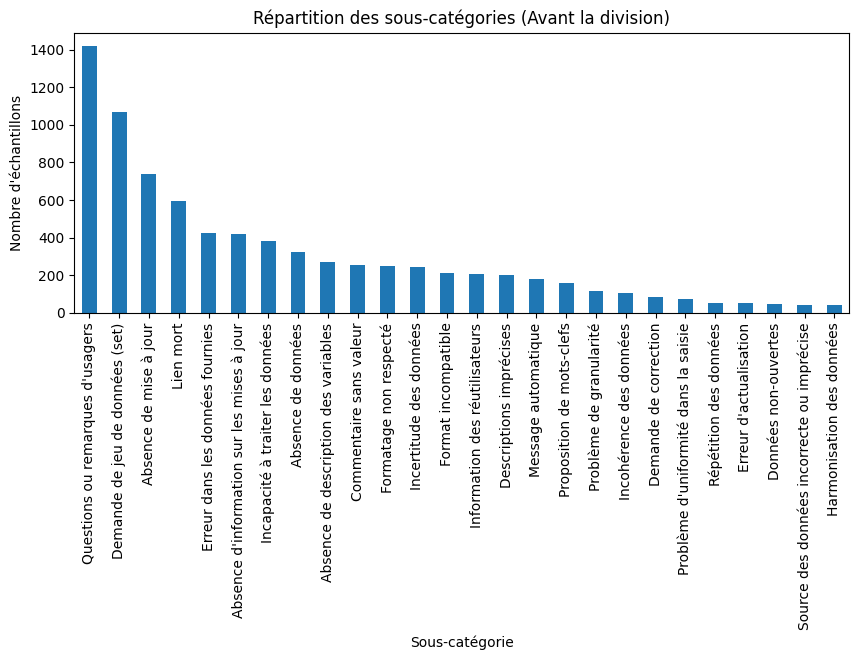

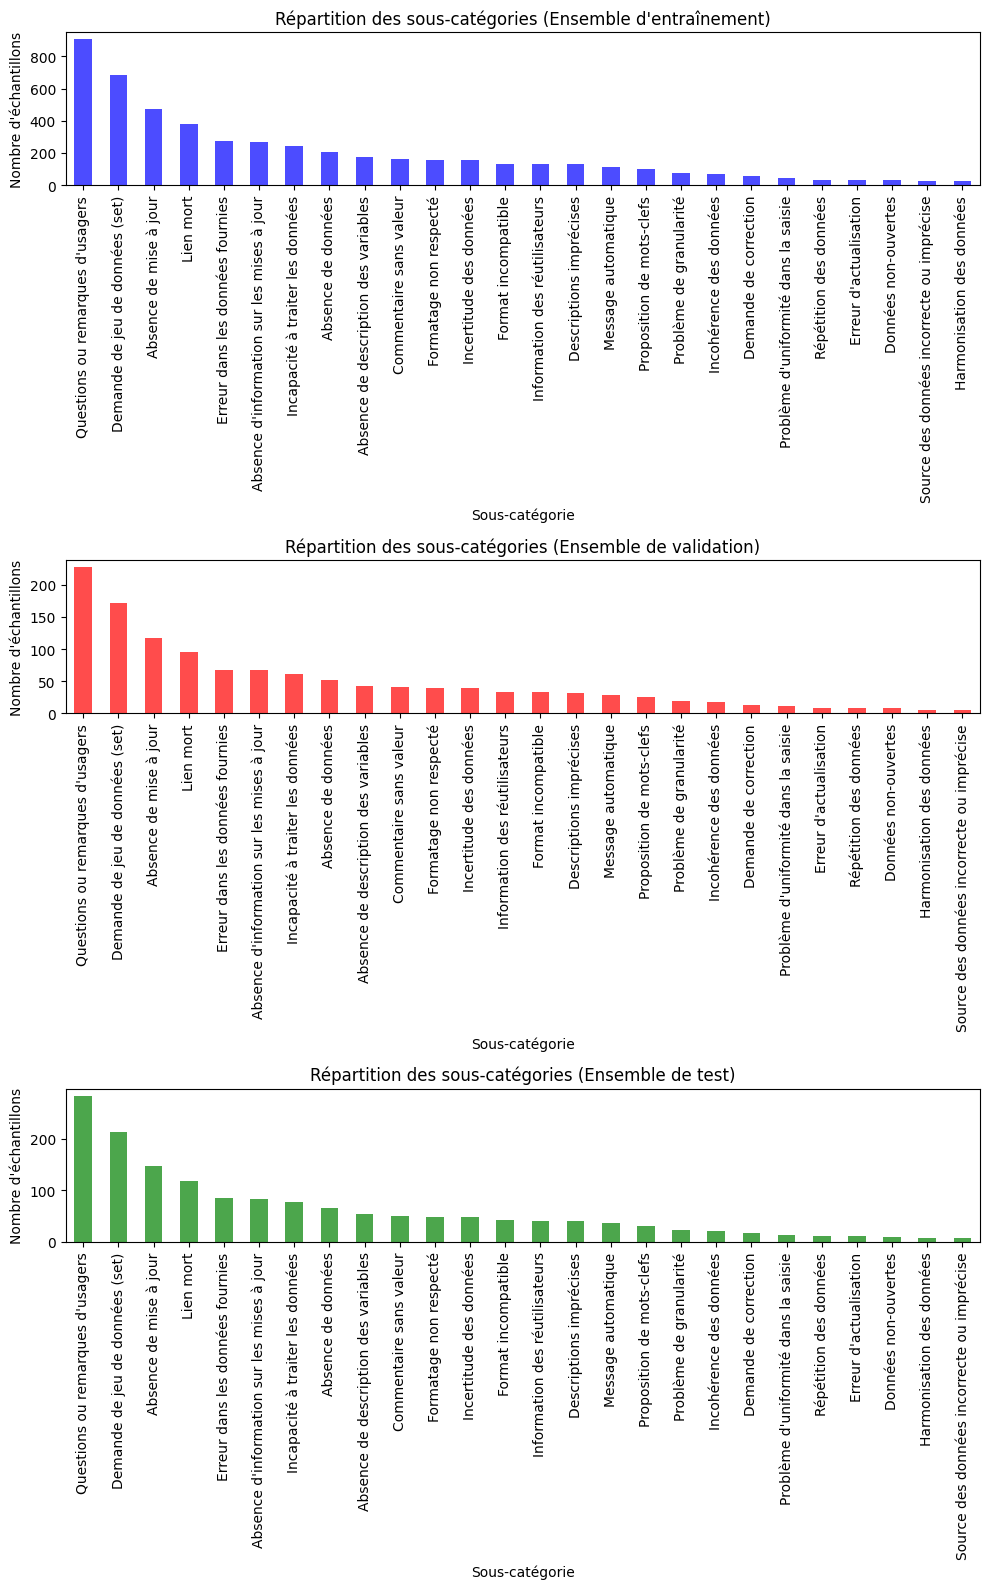

Train2 : 
 Questions ou remarques d'usagers              908
Demande de jeu de données (set)               683
Absence de mise à jour                        474
Lien mort                                     382
Erreur dans les données fournies              273
Absence d'information sur les mises à jour    268
Incapacité à traiter les données              246
Absence de données                            206
Absence de description des variables          173
Commentaire sans valeur                       162
Formatage non respecté                        158
Incertitude des données                       154
Format incompatible                           134
Information des réutilisateurs                130
Descriptions imprécises                       129
Message automatique                           114
Proposition de mots-clefs                     100
Problème de granularité                        74
Incohérence des données                        69
Demande de correction                  

In [159]:
# Avant la division
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Répartition des sous-catégories (Avant la division)")
df['Annotation'].value_counts().plot(kind='bar')
plt.xlabel("Sous-catégorie")
plt.ylabel("Nombre d'échantillons")

# Après la division
train2_counts = train2_df['Annotation'].value_counts()
val2_counts = val2_df['Annotation'].value_counts()
test2_counts = test2_df['Annotation'].value_counts()

# Répartition des sous-catégories dans train2_df
plt.figure(figsize=(10, 16))
plt.subplot(3, 1, 1)
plt.title("Répartition des sous-catégories (Ensemble d'entraînement)")
train2_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("Sous-catégorie")
plt.ylabel("Nombre d'échantillons")

# Répartition des sous-catégories dans val2_df
plt.subplot(3, 1, 2)
plt.title("Répartition des sous-catégories (Ensemble de validation)")
val2_counts.plot(kind='bar', color='red', alpha=0.7)
plt.xlabel("Sous-catégorie")
plt.ylabel("Nombre d'échantillons")

# Répartition des sous-catégories dans test2_df
plt.subplot(3, 1, 3)
plt.title("Répartition des sous-catégories (Ensemble de test)")
test2_counts.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel("Sous-catégorie")
plt.ylabel("Nombre d'échantillons")

plt.tight_layout()
plt.show()

print('Train2 : \n', train2_counts)
print('\n')
print('Validation2 : \n', val2_counts)
print('\n')
print('Test2 : \n', test2_counts)

In [160]:
example2 = dataset2['train2'][0]
example2

{'id dgf': '5885ec9588ee3837db9b81a5',
 'subject': 'Points de recharge de véhicules électriques,administrés par MOPeasy',
 'messages': "Bonjour, je vous suggère de créer un nouveau jeu de données réactualisé avec ce modèle https://www.data.gouv.fr/s/resources/fichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques/20170115-225606/IRVE_modele_pour_fichier_CSV.xls conformément à l'arrêté du 12 janvier 2017 \nSi le lien cité plus haut ne fonctionne pas retrouvez le modèle avec sa dernière mise à jour ici: \nhttps://www.data.gouv.fr/fr/datasets/fichiers-pour-les-infrastructures-de-\nrecharge-de-vehicules-electriques/\nBonjour,\nJe n'ai réussi à accéder à aucun des deux liens, si ce n'est la page sans doute périmé https://www.data.gouv.fr/fr/datasets/fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques-irve/\n\npouvez vous nous donner le bon lien et surtout vous assurer qu'il est bien indexé par le moteur de recherche du site?\nBonjour effectivement le lien que

# Préprocessing des données

In [161]:
# Créer un tokenizer
tokenizer2 = AutoTokenizer.from_pretrained("camembert-base", do_lower_case=True)

# Créer le modèle CamemBERT
model2 = AutoModel.from_pretrained("camembert-base")

# Fonction de prétraitement pour encoder les exemples et ajouter les labels
def preprocess_data2(examples):
    # Nettoyage du texte
    combined_text2 = examples["combined_text_2"]

    # Convertir chaque texte en minuscules
    combined_text2 = [text.lower() for text in combined_text2]

    # Supprimer les chiffres
    combined_text2 = [re.sub(r'\d+', '', text) for text in combined_text2]

    # Supprimer les adresses mail
    combined_text2 = [re.sub(r'\S+@\S+', '', text) for text in combined_text2]

    # Supprimer les caractères de ponctuation sauf les apostrophes et les accents
    combined_text2 = [re.sub(r"[^\w\s'-.]", '', text) for text in combined_text2]

    # Supprimer certains mots vides
    words_to_remove = ['bonjour', 'bonsoir', 'bonne journée', 'cordialement', 'merci', 'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'aout', 'septembre', 'octobre', 'novembre', 'décembre']
    combined_text2 = [[word for word in text.split() if word not in words_to_remove] for text in combined_text2]
    combined_text2 = [' '.join(text) for text in combined_text2]

    # Supprimer les espaces en trop et les sauts de lignes
    combined_text2 = [re.sub(r'\s+', ' ', text) for text in combined_text2]
    combined_text2 = [text.strip() for text in combined_text2]
    
    return combined_text2
    
# Fonction pour l'encodage des textes et l'ajout des labels et des embeddings
def tokenization2(examples):
    # Appeler la fonction preprocess_data pour obtenir les textes prétraités
    combined_text2 = preprocess_data2(examples)

    # Récupérer les labels directement depuis les exemples
    sslabels = examples["Annotation"]

    # Convertir les labels en identifiants numériques à l'aide de label2id
    sslabel_ids = [sslabel2id[sslabel] for sslabel in sslabels]

    # Encoder les textes avec le tokenizer
    encoding2 = tokenizer2(combined_text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    #encoding = tokenizer(combined_text, padding="max_length", truncation=True, max_length=2, return_tensors="pt")

    # Obtenir les embeddings des tokens
    with torch.no_grad():
        outputs2 = model2(input_ids=encoding2['input_ids'], attention_mask=encoding2['attention_mask'])
        embeddings2 = outputs2.last_hidden_state

    # Ajouter les labels et les embeddings à l'encodage des exemples
    encoding2["labels"] = sslabel_ids
    encoding2["embeddings"] = embeddings2
    
    return encoding2

# Appliquer la fonction tokenization pour obtenir l'encodage des exemples
encoded_dataset2 = dataset2.map(tokenization2, batched=True, remove_columns=dataset2['train2'].column_names)

print(encoded_dataset2)

Map:   0%|          | 0/5086 [00:00<?, ? examples/s]

Map:   0%|          | 0/1272 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

DatasetDict({
    train2: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 5086
    })
    validation2: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 1272
    })
    test2: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'embeddings'],
        num_rows: 1590
    })
})


In [137]:
# Affichage du résultat du preprocessing sur un exemple

example2 = encoded_dataset2['train2'][0]
print(example2)
#print('\n')
#print(example2.keys())

{'input_ids': [5, 8716, 4242, 8716, 4242, 375, 15, 209, 25, 2182, 42, 588, 11388, 38, 958, 20661, 49, 26, 53, 5061, 7, 50, 39, 10712, 8, 739, 23, 281, 357, 8, 416, 425, 6598, 11688, 42, 44, 776, 3047, 1253, 9, 12818, 9, 18690, 9, 427, 10, 346, 6694, 10, 30813, 10, 26, 1560, 26, 408, 26, 13471, 10, 26, 234, 26, 346, 9843, 26, 234, 26, 1571, 133, 14194, 10, 26, 17026, 13408, 10, 26, 764, 1571, 862, 20917, 35, 862, 1560, 862, 30813, 862, 9895, 526, 9, 290, 219, 10, 4953, 15, 17, 11, 13731, 25, 86, 16, 818, 2240, 40, 540, 45, 2247, 34, 8420, 16, 776, 42, 77, 576, 375, 15, 209, 323, 3047, 1253, 9, 12818, 9, 18690, 9, 427, 427, 12818, 10, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [138]:
tokenizer2.decode(example2['input_ids'])

"<s> exploitabilité exploitabilité mise à jour du fichier avec nouvelles colonnes (décret n-) bonjour, je vous suggère de créer un nouveau jeu de données réactualisé avec ce modèle httpswww.data.gouv.frsresourcesfichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques-irve_modele_pour_fichier_csv.xls conformément à l'arrêté du si le lien cité plus haut ne fonctionne pas retrouvez le modèle avec sa dernière mise à jour ici httpswww.data.gouv.frfrdatas</s>"

In [139]:
# Changer le format des jeux de données pour torch
#encoded_dataset2.set_format("torch")

In [140]:
# Définir la taille du lot et la métrique d'évaluation
#batch_size = 8
batch_size = 16
#metric_name = "f1"
metric_name = "accuracy"

In [165]:
# Définir les arguments pour l'entraînement
args2 = TrainingArguments(
    "bert-finetuned-my-data2",
    #f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    #learning_rate=2e-6,
    ###learning_rate=2e-5,
    #learning_rate=1e-5,
    learning_rate=3e-5,
    #learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [166]:
model2 = AutoModelForSequenceClassification.from_pretrained("camembert-base",
                                                           problem_type="single_label_classification",
                                                           num_labels=len(sslabels),
                                                           id2label=id2sslabel,
                                                           label2id=sslabel2id)

# Variables globales pour stocker y_true et y_pred
y_true_global2 = None
y_pred_global2 = None

def compute_metrics2(eval_pred2):
    global y_true_global2, y_pred_global2

    predictions2, y_true2 = eval_pred2
    y_pred2 = predictions2.argmax(axis=1)

    accuracy2 = accuracy_score(y_true2, y_pred2)
    precision2 = precision_score(y_true2, y_pred2, average="weighted")
    recall2 = recall_score(y_true2, y_pred2, average="weighted")
    f12 = f1_score(y_true2, y_pred2, average='weighted')

    # Assigner les valeurs à y_true_global et y_pred_global
    y_true_global2 = y_true2.tolist()
    y_pred_global2 = y_pred2.tolist()

    metrics2 = {
        'accuracy': accuracy2,
        'f1': f12,
        'precision': precision2,
        'recall': recall2
    }

    return metrics2

# Créer l'optimiseur AdamW avec le taux d'apprentissage spécifié
optimizer2 = AdamW(model2.parameters(), lr=args2.learning_rate)

# Créer une instance de la classe Trainer en spécifiant l'optimiseur
trainer2 = Trainer(
    model=model2,
    args=args2,
    train_dataset=encoded_dataset2["train2"],
    eval_dataset=encoded_dataset2["validation2"],
    optimizers=(optimizer2, None),  # spécifier l'optimiseur pour l'entraînement
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics2
)

# Lancer l'entraînement du modele
trainer2.train()


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/asma/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classi

TrainOutput(global_step=3180, training_loss=0.7516984807620258, metrics={'train_runtime': 10527.3183, 'train_samples_per_second': 4.831, 'train_steps_per_second': 0.302, 'total_flos': 3346177969121280.0, 'train_loss': 0.7516984807620258, 'epoch': 10.0})

# Evaluation du modèle 2 sur les données de test

In [167]:
# Évaluer le modèle sur l'ensemble de test
eval_results2 = trainer2.evaluate(encoded_dataset2['test2'])
eval_results2

/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.8758730888366699,
 'eval_accuracy': 0.7377358490566037,
 'eval_f1': 0.7094824730140812,
 'eval_precision': 0.6972482540788782,
 'eval_recall': 0.7377358490566037,
 'eval_runtime': 91.8899,
 'eval_samples_per_second': 17.303,
 'eval_steps_per_second': 1.088,
 'epoch': 10.0}

In [168]:
# Afficher les valeurs de y_true_global et y_pred_global
print("y_true_global2:", y_true_global2)
print("y_pred_global2:", y_pred_global2)

y_true_global2: [19, 10, 16, 11, 6, 11, 6, 5, 10, 12, 17, 16, 5, 1, 9, 11, 19, 24, 1, 11, 9, 3, 24, 18, 4, 4, 18, 5, 11, 6, 4, 9, 15, 13, 1, 11, 11, 4, 9, 11, 8, 11, 4, 11, 11, 1, 15, 10, 4, 2, 17, 14, 18, 1, 1, 1, 1, 5, 7, 12, 23, 11, 14, 11, 9, 12, 1, 6, 8, 2, 1, 1, 11, 8, 4, 6, 10, 1, 1, 21, 5, 5, 7, 1, 11, 11, 12, 11, 17, 15, 2, 6, 1, 5, 2, 24, 4, 11, 19, 21, 12, 6, 5, 2, 8, 1, 9, 10, 23, 9, 11, 0, 17, 4, 9, 9, 5, 9, 5, 18, 8, 5, 0, 1, 15, 4, 14, 20, 12, 11, 1, 15, 17, 20, 10, 10, 2, 12, 11, 4, 11, 20, 14, 20, 17, 7, 10, 10, 1, 20, 1, 1, 16, 6, 1, 20, 4, 2, 1, 12, 14, 5, 9, 24, 6, 12, 2, 1, 14, 16, 8, 1, 20, 14, 4, 14, 0, 16, 24, 17, 6, 5, 1, 1, 8, 6, 1, 11, 4, 10, 14, 24, 1, 9, 20, 1, 1, 4, 11, 13, 1, 14, 2, 12, 2, 12, 1, 1, 4, 11, 14, 23, 17, 4, 4, 4, 1, 11, 24, 10, 4, 11, 12, 11, 11, 14, 1, 6, 2, 25, 13, 3, 4, 5, 1, 12, 5, 17, 11, 1, 4, 12, 1, 8, 1, 12, 11, 12, 14, 4, 5, 13, 1, 11, 3, 2, 5, 23, 12, 4, 1, 11, 12, 10, 1, 1, 6, 1, 11, 20, 1, 19, 1, 11, 4, 4, 2, 4, 6, 17, 13, 1, 5, 

In [169]:
y_true2 = y_true_global2
y_pred2 = y_pred_global2

# Evaluation du modèle 2 : Classification report

In [170]:
# Générer le rapport de classification
report2 = classification_report(y_true2, y_pred2, target_names=sslabels)
#report2 = classification_report(y_true2, y_pred2)

# Afficher le rapport de classification
print(report2)

                                            precision    recall  f1-score   support

                   Incohérence des données       0.00      0.00      0.00        21
          Questions ou remarques d'usagers       0.91      0.92      0.91       284
                   Commentaire sans valeur       0.73      0.65      0.69        51
                    Erreur d'actualisation       0.00      0.00      0.00        11
                    Absence de mise à jour       0.79      0.77      0.78       148
          Erreur dans les données fournies       0.70      0.89      0.78        85
                                 Lien mort       0.82      0.82      0.82       119
                       Format incompatible       0.42      0.50      0.46        42
            Information des réutilisateurs       0.64      0.68      0.66        41
      Absence de description des variables       0.57      1.00      0.73        54
                        Absence de données       0.64      0.80      0.71  

/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/asma/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation du modèle 2 : Matrice de confusion

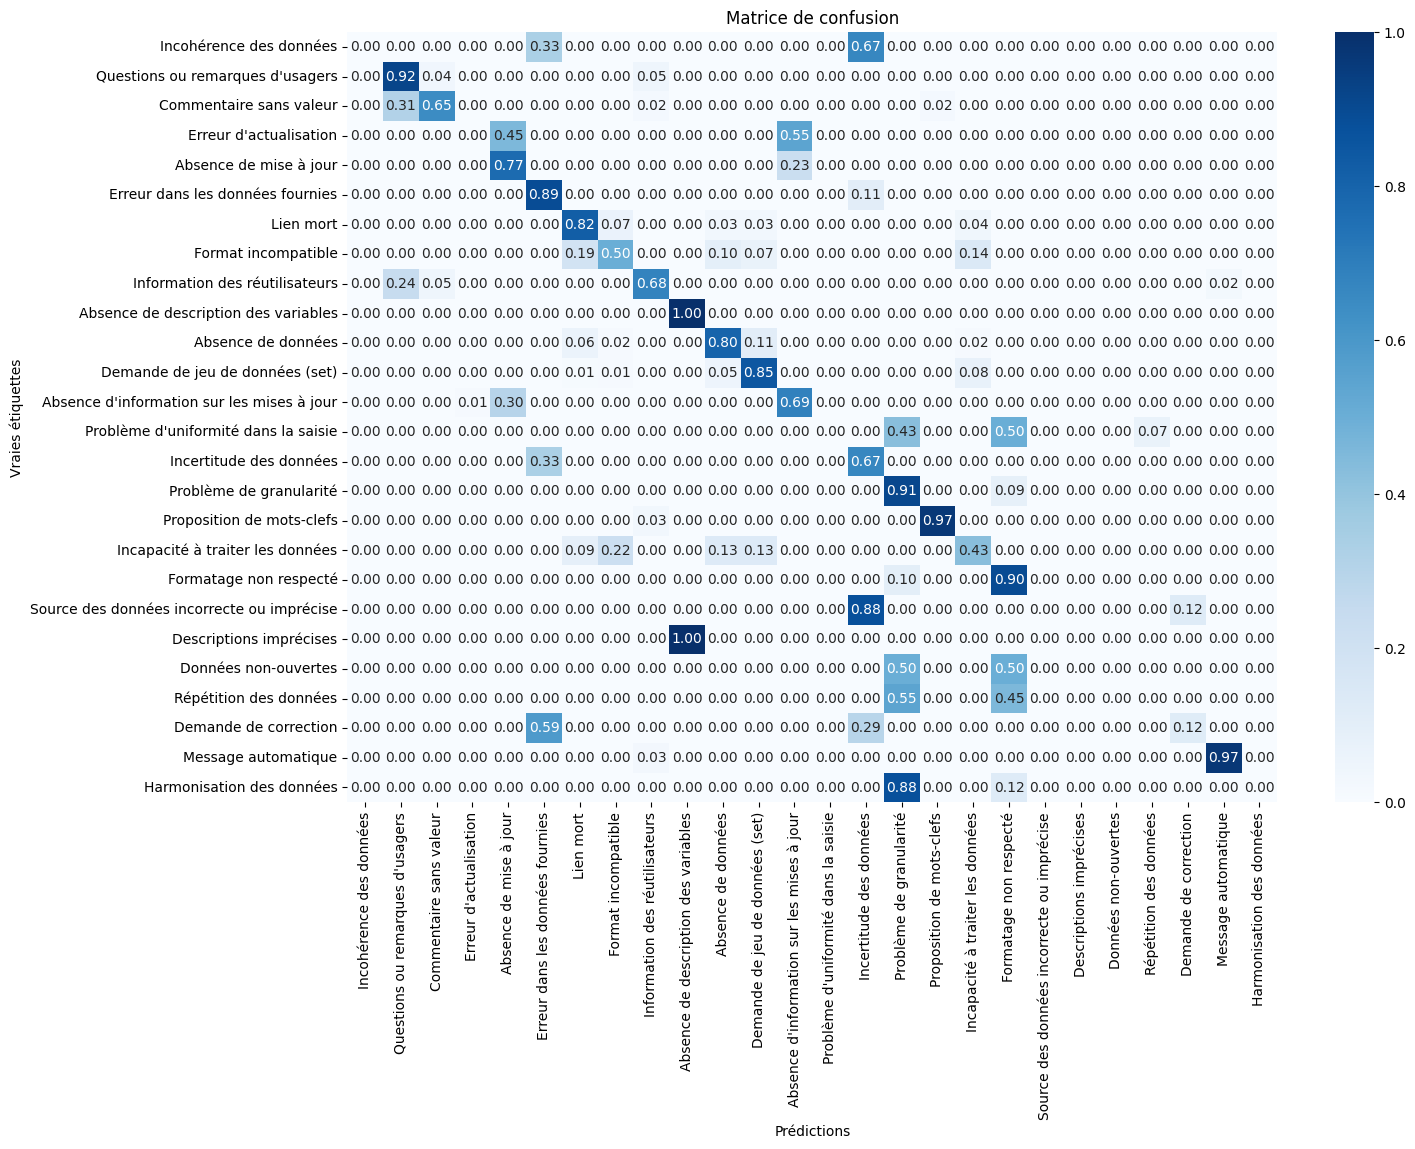

In [171]:
# Calculer la matrice de confusion
confusion_mat = confusion_matrix(y_true2, y_pred2)

# Obtenir les noms des classes à partir des identifiants de label
class_names = [id2sslabel[i] for i in range(len(sslabels))]

# Normaliser la matrice de confusion pour afficher les pourcentages
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Créer une figure
plt.figure(figsize=(15, 10))

# Tracer la matrice de confusion
sns.heatmap(confusion_mat_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Ajouter des étiquettes aux axes
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")

# Ajouter un titre
plt.title("Matrice de confusion")

plt.savefig('Matrice de confusion2.png')
#files.download('Matrice de confusion2.png')

# Afficher la figure
plt.show()

# Enregistrement des fichiers de poids et d'entrainement du modele 2 (zippé)

In [172]:
# Enregistrement des fichiers de poids (zippé)

#import shutil
#import zipfile

# Chemin de destination pour enregistrer le modèle
model_directory2 = "bert-finetuned-my-data-final2"

# Sauvegarder le modèle avec les fichiers de poids
trainer2.save_model(model_directory2)
# Sauvegarder le tokenizer
tokenizer2.save_pretrained(model_directory2)

# Compresser le dossier au format .zip
shutil.make_archive(model_directory2 + "_archive2", 'zip', model_directory2)

# Chemin de destination pour le fichier .zip
zip_file_path2 = model_directory2 + "_archive2.zip"

# Télécharger le fichier .zip
#files.download(zip_file_path2)

# Charger le modele 2 pré-entrainé (zippé)

In [173]:
# Chargement du modèle 2 (zippé)

# Extraire le contenu du fichier .zip dans un répertoire temporaire
zip_file_path2 = "bert-finetuned-my-data-final2_archive2.zip"
extract_dir2 = "extracted_model2"
with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_dir2)

# Charger le modèle à partir du répertoire extrait
model_saved2 = AutoModelForSequenceClassification.from_pretrained(extract_dir2)

# Charger le tokenizer à partir du même répertoire extrait
tokenizer_saved2 = AutoTokenizer.from_pretrained(extract_dir2)


In [174]:
"""# Enregistrer le modèle pré-entrainé (non zippé)

# Chemin de destination pour enregistrer le modèle et le tokenizer
output_dir2 = "modeleBertSaved2"

# Enregistrer le modèle
model2.save_pretrained(output_dir2)

# Enregistrer le tokenizer
tokenizer2.save_pretrained(output_dir2)
"""

'# Enregistrer le modèle pré-entrainé (non zippé)\n\n# Chemin de destination pour enregistrer le modèle et le tokenizer\noutput_dir2 = "modeleBertSaved2"\n\n# Enregistrer le modèle\nmodel2.save_pretrained(output_dir2)\n\n# Enregistrer le tokenizer\ntokenizer2.save_pretrained(output_dir2)\n'

In [175]:
"""# Charger le modèle à partir du dossier sauvegardé (non zippé)
model_saved2 = AutoModelForSequenceClassification.from_pretrained(output_dir2)

# Charger le tokenizer à partir du dossier sauvegardé
tokenizer_saved2 = AutoTokenizer.from_pretrained(output_dir2)
"""

'# Charger le modèle à partir du dossier sauvegardé (non zippé)\nmodel_saved2 = AutoModelForSequenceClassification.from_pretrained(output_dir2)\n\n# Charger le tokenizer à partir du dossier sauvegardé\ntokenizer_saved2 = AutoTokenizer.from_pretrained(output_dir2)\n'

In [176]:
# Prétraitement des nouvelles données
new_data = ["Problème avec le lien, je n'arrive pas à accéder à la page"]

encoded_inputs2 = tokenizer_saved2(new_data, truncation=True, padding=True, return_tensors="pt")

# Passage des données dans le modèle pour l'inférence
with torch.no_grad():
    outputs2 = model_saved2(**encoded_inputs2)

# Récupération des prédictions
predictions2 = outputs2.logits
predicted_labels2 = torch.argmax(predictions2, dim=1)

# Affichage des résultats
for text2, sslabel2 in zip(new_data, predicted_labels2):
    print(f"Texte : {text2}")
    print(f"Sous-label prédit : {sslabel2}")
    print(type(sslabel2))
    sslabel2 = sslabel2.item()
    print(type(sslabel2))
    print(f"Nom du label prédit : {id2sslabel[sslabel2]}")

Texte : Problème avec le lien, je n'arrive pas à accéder à la page
Sous-label prédit : 6
<class 'torch.Tensor'>
<class 'int'>
Nom du label prédit : Lien mort


# Inférence du modèle 2 avec les données du MEFSIN

In [178]:
# On récupère la prédiction précédente (modèle 1 grands motifs)

df_MEFSIN['combined_text2'] = df_MEFSIN['predictions_motifs_label'] + ' ' + df_MEFSIN['predictions_motifs_label'] + ' ' + df_MEFSIN['predictions_motifs_label'] + ' ' + df_MEFSIN['title'] + ' ' + df_MEFSIN['messages']


In [179]:
df_MEFSIN.iloc[0]

id                                                   6418839138db635b9a8ec61a
user                                                         Christophe BADOL
subject                                             Parcellaire Express (PCI)
title                       Disparition de la table arrondissement de la l...
size                                                                        2
messages                    Bonjour,\n\nla table arrondissement a disparu ...
created                                            2023-03-20T17:02:25.636000
closed                                                                    NaN
closed_by                                                                 NaN
MEFSIN                                                                      1
combined_text               Disparition de la table arrondissement de la l...
predictions_motifs                                                          2
predictions_motifs_label                                        

In [180]:
df_MEFSIN.loc[0, "combined_text2"]

'Actualisation Actualisation Actualisation Disparition de la table arrondissement de la livraison 2023 Bonjour,\n\nla table arrondissement a disparu de la livraison au 1er janvier 2023. Sait-on pourquoi ?\nLa classe ARRONDISSEMENT nÄ\x86ÂḃÄ\x81â\x80\x9aÂỲÄ\x81â\x80\x9eÂḃest prÄ\x86'

In [181]:
#Sélection des features (X) à utiliser pour l'inférence
#features = df_MEFSIN["messages"]
features = df_MEFSIN["combined_text2"]

In [182]:
# Prétraitement des données de la colonne "messages"
messages = features.tolist()

# Créer une liste pour stocker les prédictions
predictions2 = []

# Définir la taille du batch d'inférence
batch_size = 8

# Diviser les données en lots plus petits
num_batches = len(messages) // batch_size
if len(messages) % batch_size != 0:
    num_batches += 1

# Mettre le modèle en mode évaluation
model_saved2.eval()

# Parcourir les lots et effectuer l'inférence
for i in range(num_batches):
    # Sélectionner les textes du lot actuel
    batch_texts = messages[i*batch_size:(i+1)*batch_size]

    # Convertir les textes en tenseurs PyTorch
    encoded_inputs2 = tokenizer_saved2.batch_encode_plus(batch_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Passage des données dans le modèle pour l'inférence
    with torch.no_grad():
        outputs2 = model_saved2(**encoded_inputs2)

    # Récupération des prédictions
    predicted_sslabels = torch.argmax(outputs2.logits, dim=1)

    # Ajouter les prédictions à la liste des résultats
    predictions2.extend(predicted_sslabels.tolist())

# Ajouter la liste des prédictions comme une nouvelle colonne "res_motifs" au DataFrame
#df_MEFSIN['res_motifs'] = id2label[predictions]
df_MEFSIN['predictions_ssmotifs'] = predictions2
df_MEFSIN['predictions_ssmotifs_label'] = [id2sslabel[prediction] for prediction in predictions2]


In [183]:
df_MEFSIN.head(10)

id              user  \
0  6418839138db635b9a8ec61a  Christophe BADOL   
1  641861cca4f1971589503cb9      Estelle CrÄ   
2  6413358dcce10824f53a9bc9     Camille Bacon   
3  64088027de783a9eadb04349               JÄ   
4  640869f8abc8970cefa9c3d4        Anne Solaz   
5  6408538a96433266c124be61   Pierre L'Hostis   
6  63fe2b9c047052abef06bfc1       Corinne BCD   
7  63f62c2468b60c13e99ab53c     Claude Leroux   
8  63e5e3174f42fe618e57ad7b     Iliyan Petrov   
9  63e354bd89059f1ad24d03f4               BÄ   

                                             subject  \
0                          Parcellaire Express (PCI)   
1  Fichiers des locaux et des parcelles des perso...   
2                        Demandes de valeurs fonciÄ   
3   Prix des carburants en France - Flux instantanÄ   
4                                            L'impÄ   
5                                             DonnÄ   
6                                                RÄ   
7                        Demandes de valeurs fonciÄ   
8                                                RÄ   
9                                             DonnÄ   

                                               title  size  \
0  Disparition de la table arrondissement de la l...     2   
1                                       Siren cessÄ     1   
2                                  1 idloc = 1 local     1   
3            Date d'obsolescence de ce jeu de donnÄ     1   
4                             liens non focntionnels     1   
5                            Plateforme non indiquÄ     1   
6                                             DonnÄ     1   
7                  parcelle BT2 - commune de CarriÄ     1   
8                                  Lien vers le flux     1   
9                   Impossible de trouver nos donnÄ     2   

                                            messages  \
0  Bonjour,\n\nla table arrondissement a disparu ...   
1     Bonjour, Pourquoi y a-t-il des Siren dont l'Ä   
2    Bonjour,\n\nTout d'abord, merci pour ces donnÄ   
3           Bonjour, la description du jeu de donnÄ   
4                        Bonjour, Je n'arrive pas Ä   
5    Bonjour,\n\nPourriez-vous me dire si les donnÄ   
6                          Bonjour\nMa collectivitÄ   
7  Bonjour,\nje vous contacte car je souhaiterais...   
8  Bonjour,\nJ'ai quelques questions de base sur ...   
9                               Bonjour,\nNos donnÄ   

                      created closed closed_by  MEFSIN  \
0  2023-03-20T17:02:25.636000    NaN       NaN       1   
1  2023-03-20T14:38:20.353000    NaN       NaN       1   
2  2023-03-16T16:28:13.300000    NaN       NaN       1   
3  2023-03-08T13:31:35.125000    NaN       NaN       1   
4  2023-03-08T11:56:56.125000    NaN       NaN       1   
5  2023-03-08T10:21:14.949000    NaN       NaN       1   
6  2023-02-28T17:28:12.244000    NaN       NaN       1   
7  2023-02-22T15:52:20.774000    NaN       NaN       1   
8  2023-02-10T07:24:23.623000    NaN       NaN       1   
9  2023-02-08T08:52:29.253000    NaN       NaN       1   

                                       combined_text  predictions_motifs  \
0  Disparition de la table arrondissement de la l...                   2   
1  Siren cessÄ Bonjour, Pourquoi y a-t-il des Si...                   1   
2  1 idloc = 1 local Bonjour,\n\nTout d'abord, me...                   1   
3  Date d'obsolescence de ce jeu de donnÄ Bonjou...                   2   
4  liens non focntionnels Bonjour, Je n'arrive pa...                   3   
5  Plateforme non indiquÄ Bonjour,\n\nPourriez-v...                   3   
6                   DonnÄ Bonjour\nMa collectivitÄ                   1   
7  parcelle BT2 - commune de CarriÄ Bonjour,\nje...                   1   
8  Lien vers le flux Bonjour,\nJ'ai quelques ques...                   1   
9  Impossible de trouver nos donnÄ Bonjour,\nNos...                   3   

  predictions_motifs_label                                     combined_text2  \
0          

# Sauvegarde des résultats d'annotations sur les grandes catégories du jeu du MEFSIN

In [184]:
# Sauvegarde des résultats d'annotations sur les sous-catégories du jeu du MEFSIN
df_MEFSIN.to_csv('Résultat_Annotations_sous-Motifs.csv', index=False)